In [1]:
import numpy as np
import sys
sys.path.insert(0, '../..') #This line adds '../..' to the path so we can import the net_framework python file
from RNN_model_GRAD import *
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
try:
    import ujson as json
except ImportError:
    import json
import scipy.linalg as slin

Having trained the network weights on the remote computer, and loading the weights

In [2]:
with open('weight_history.json') as f:
    weight_history = json.load(f)

In [3]:
weight_history.keys()

dict_keys(['trained weights', 'bias', 'noise weights', 'input weights', 'connectivity matrix', 'output weights'])

Defining weights of the network. Final trained weights are in final_weights

In [4]:
noise_weights = np.array(weight_history['noise weights'])
bias_weights = np.array(weight_history['bias'])
input_weights = np.array(weight_history['input weights'])
output_weight_matrix = np.array(weight_history['output weights'])
connectivity_matrix = np.array(weight_history['connectivity matrix'])
final_weights = np.array(weight_history['trained weights'][-1])

In [19]:
num_nodes = 128
time_constant = 100 #ms
timestep = 10 #ms
noise_strength = 0.01

weight_matrix = tf.Variable(final_weights)
connectivity_matrix = tf.constant(connectivity_matrix)

input_weight_matrix = tf.constant(np.vstack((bias_weights, noise_weights, input_weights)))

def rule_input(time):
    #No input for now
    return 0
    
def bias(time):
    return 1
def noise(time):
    return np.sqrt(2 * time_constant/timestep) * noise_strength * np.random.normal(0, 1)


input_funcs = [bias, noise, rule_input]

init_activations = tf.constant(np.zeros((num_nodes, 1)))
output_weight_matrix = tf.constant(output_weight_matrix)
        
network = RNN(weight_matrix, connectivity_matrix, init_activations, output_weight_matrix, time_constant = time_constant,
             timestep = timestep,activation_func = keras.activations.softplus, output_nonlinearity = lambda x : x)

Simulating Network Output

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1601.56it/s]


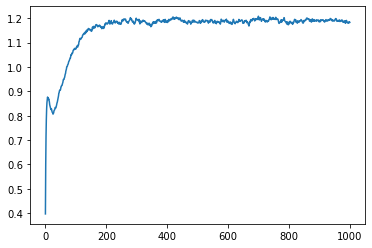

In [20]:
time = 10000 #ms
inputs = network.convert(time, input_funcs)
outputs, activations = network.simulate(time, inputs, input_weight_matrix)

outputs = tf.transpose(outputs).numpy()[0]
fig, ax = plt.subplots()
plt.plot(range(len(outputs)), outputs)
plt.show()

Now, simulating network activity to ensure that it works.

In [21]:
network.reset_activations()
def rule_input(time):
    #running for 5 seconds = 5000ms
    if time < 5000:
        return .2 + np.random.normal(0, .05)
    else:
        return .8 + np.random.normal(0, .05)
def target_func(time):
    #running for 5 seconds = 5000ms
    #Reverse of rule_input
    if time < 5000:
        return .8
    else:
        return .2

targets = network.convert(time, [target_func])
input_funcs[2] = rule_input
inputs = network.convert(time, input_funcs)

outputs, activations = network.simulate(time, inputs, input_weight_matrix)

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1672.08it/s]


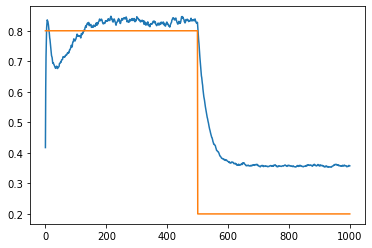

In [22]:

outputs = tf.transpose(outputs).numpy()[0]

fig, ax = plt.subplots()
plt.plot(range(len(outputs)), outputs)
plt.plot(range(len(outputs)), [target_func(t * timestep) for t in range(len(outputs))])
plt.show()

In [23]:
activations = np.asarray(activations)

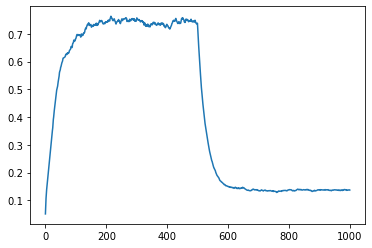

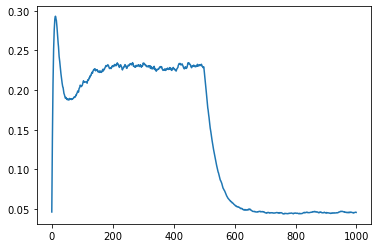

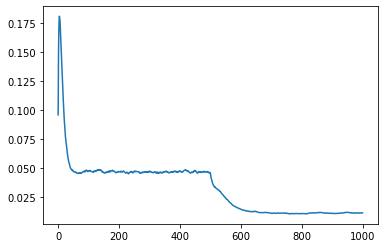

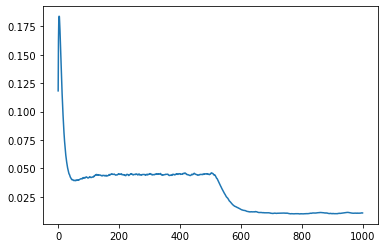

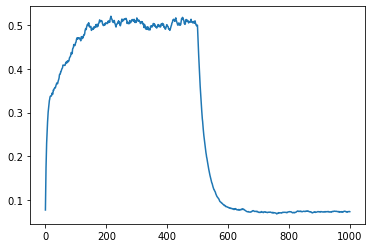

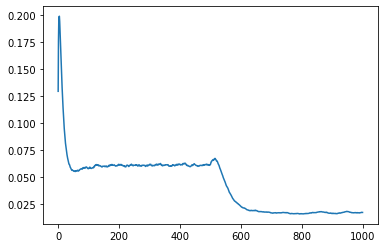

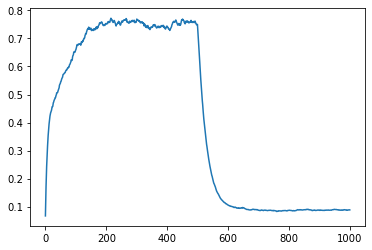

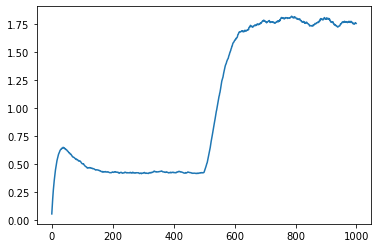

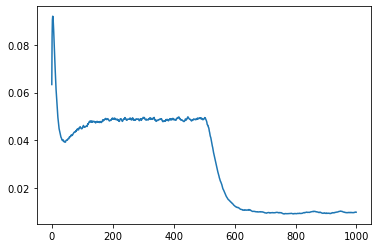

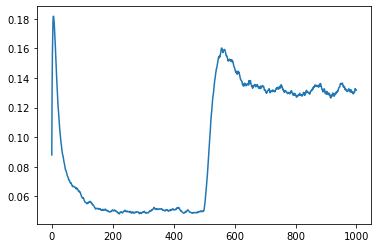

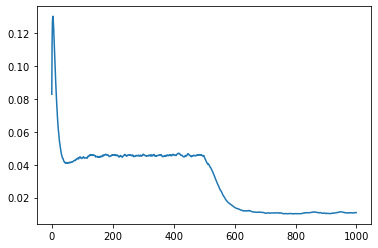

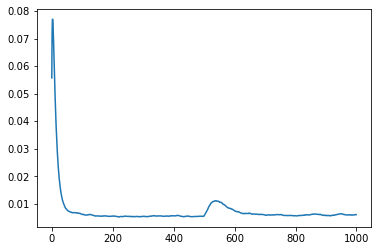

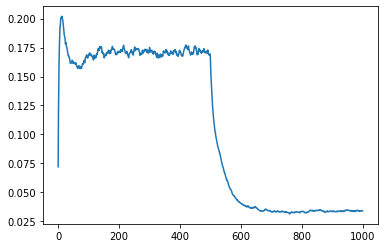

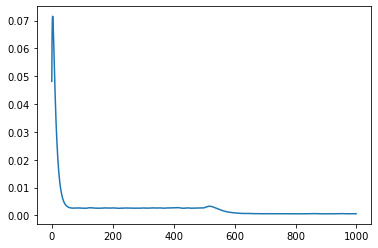

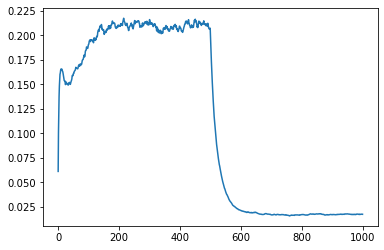

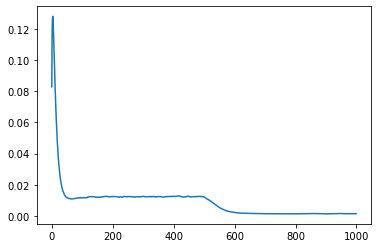

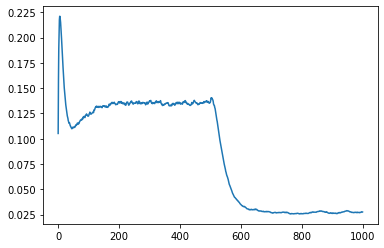

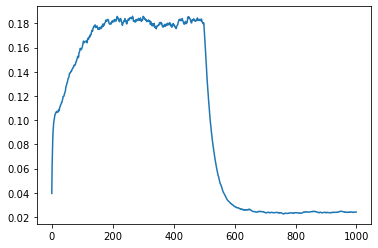

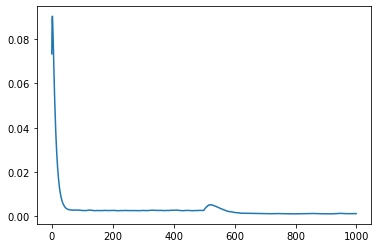

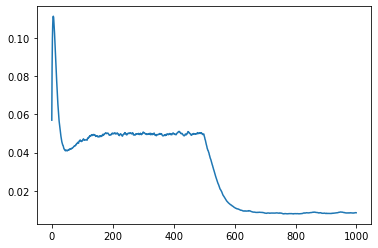

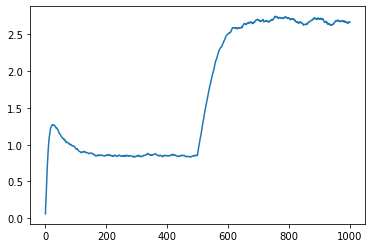

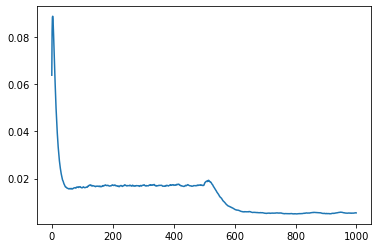

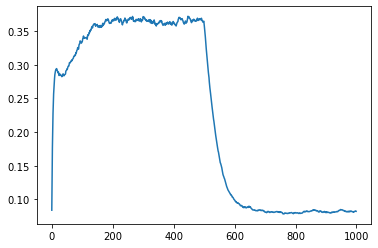

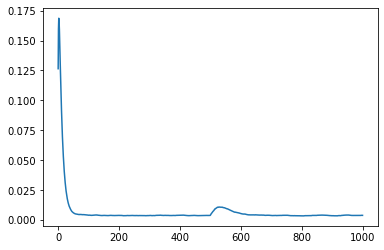

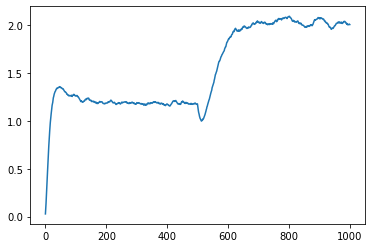

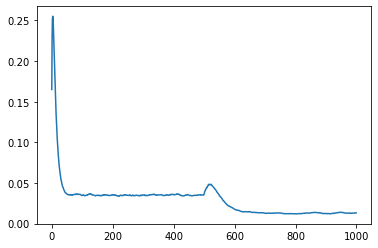

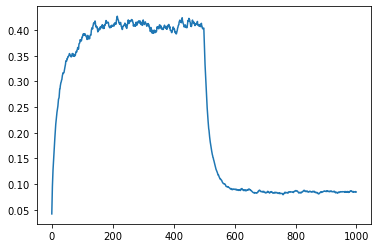

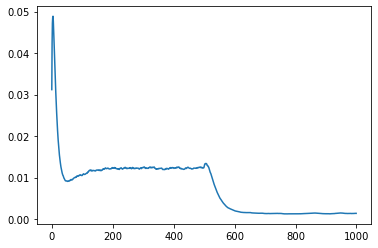

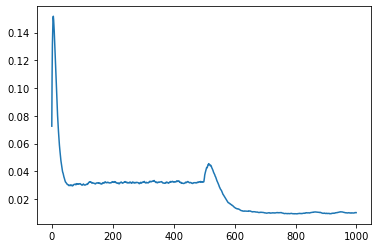

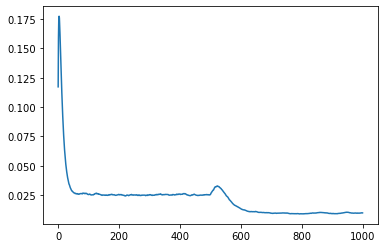

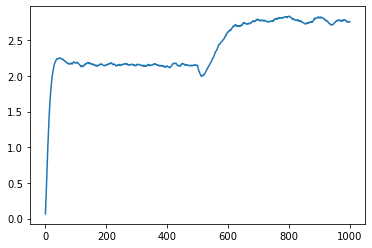

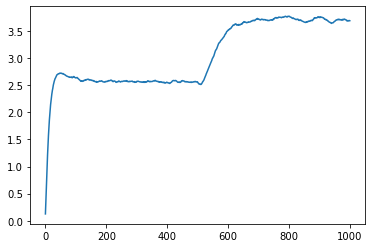

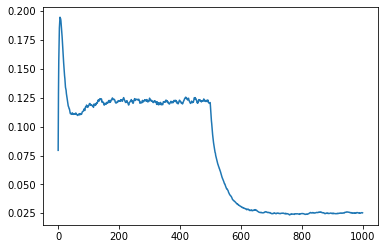

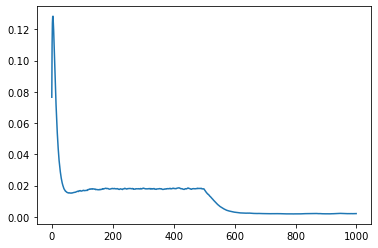

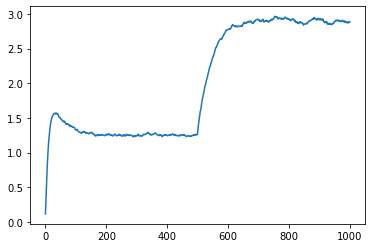

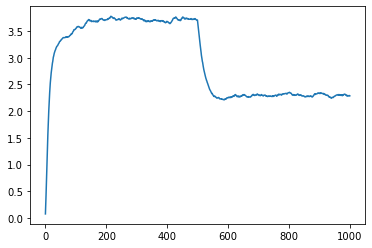

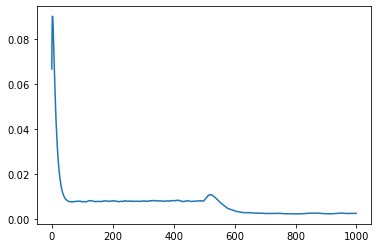

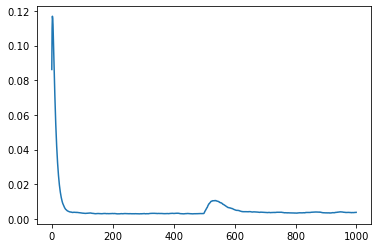

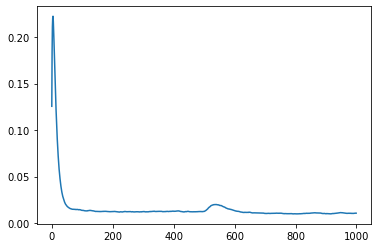

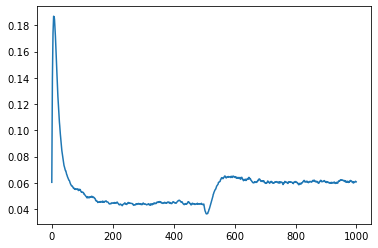

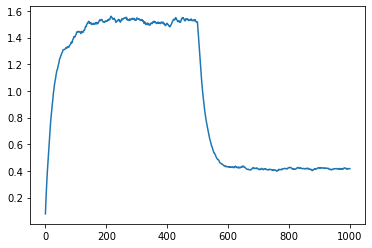

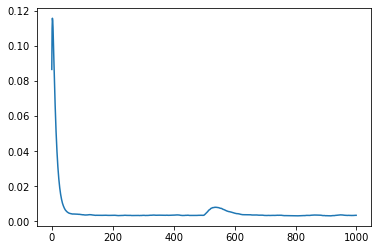

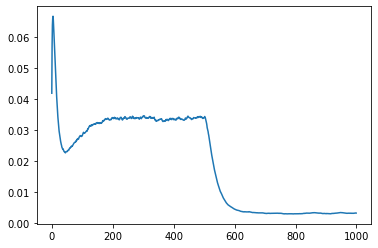

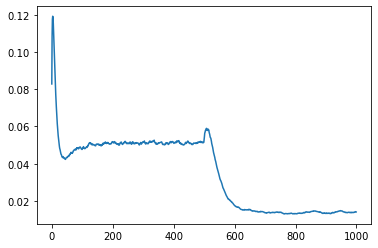

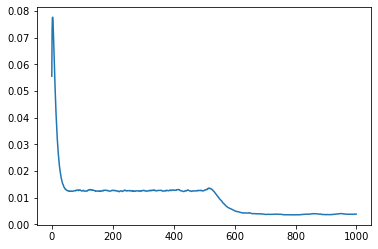

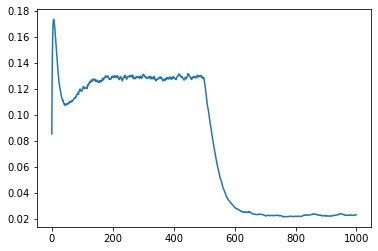

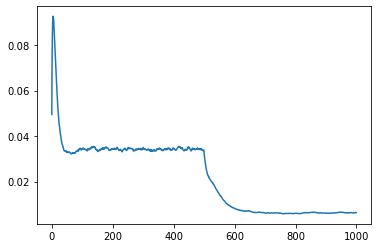

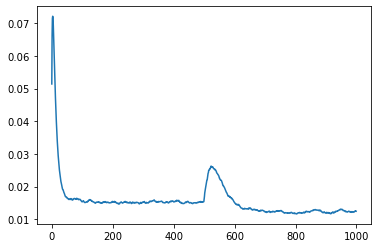

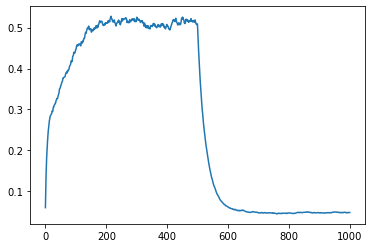

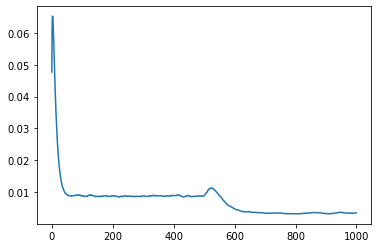

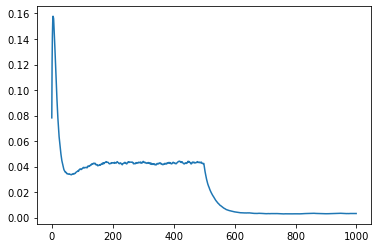

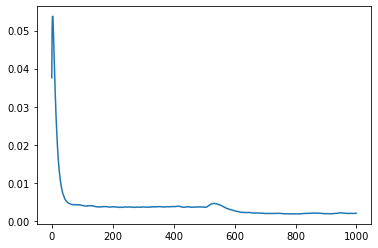

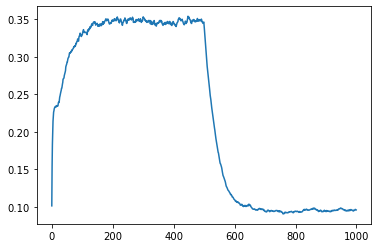

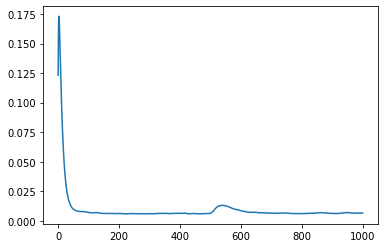

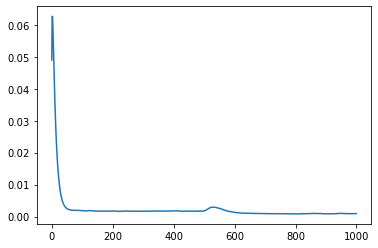

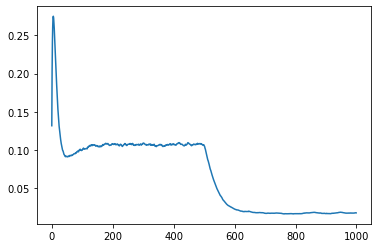

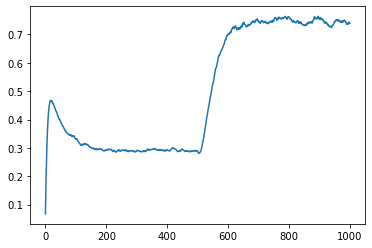

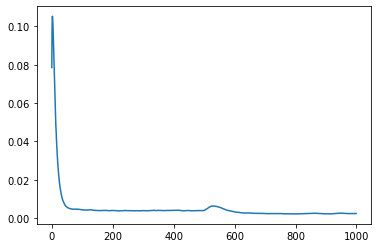

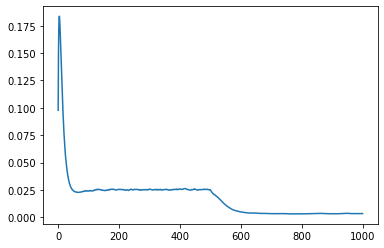

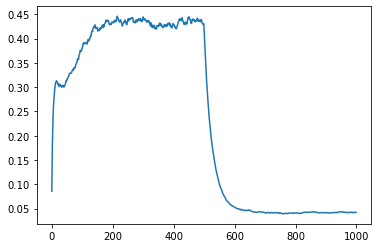

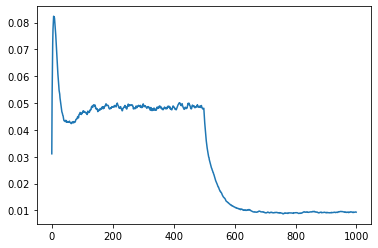

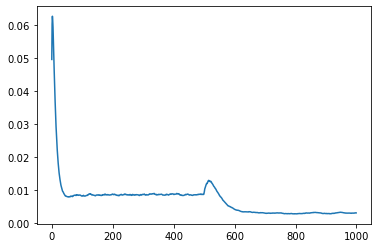

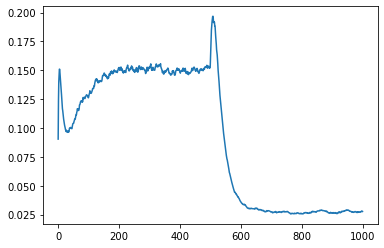

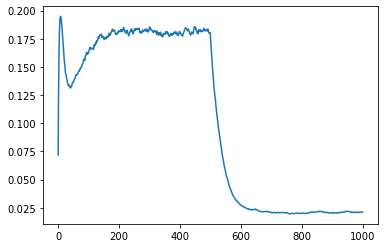

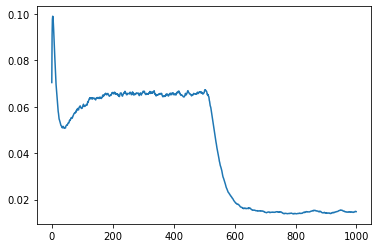

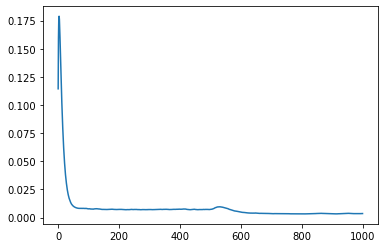

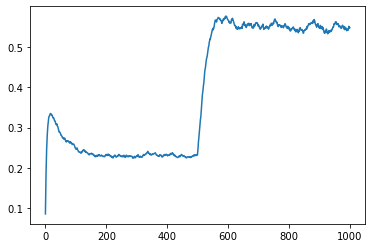

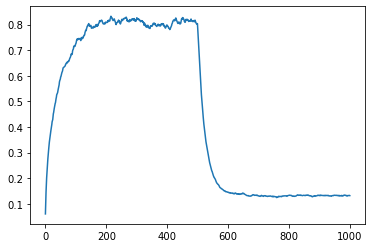

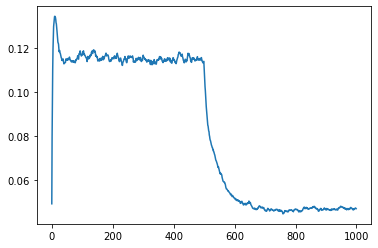

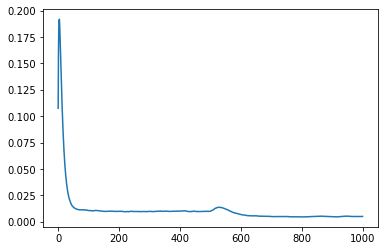

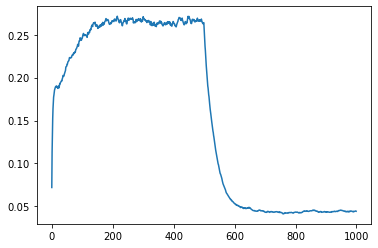

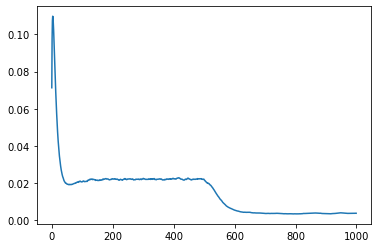

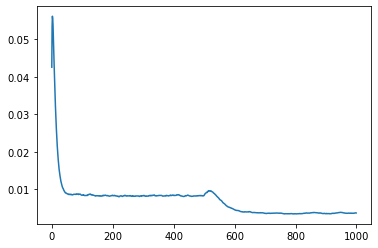

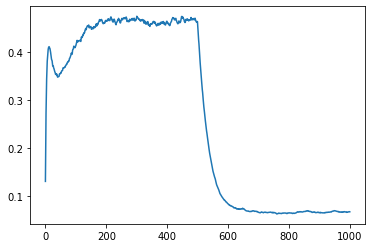

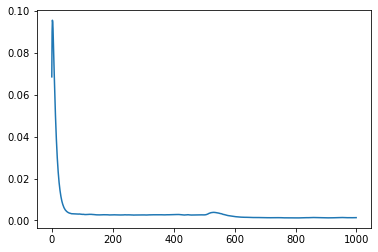

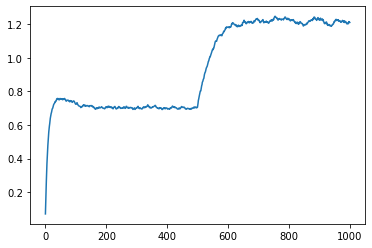

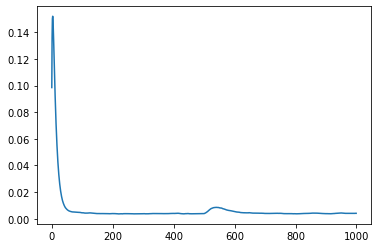

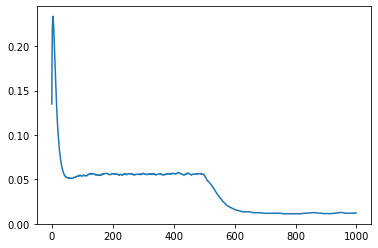

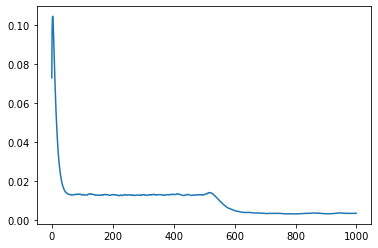

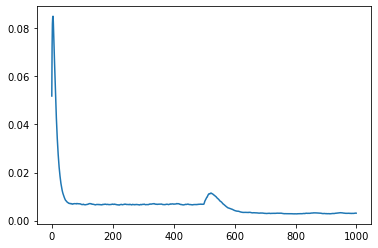

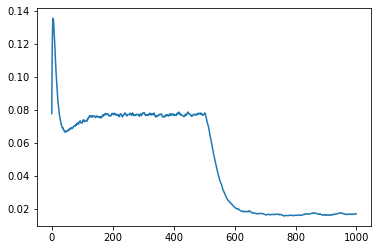

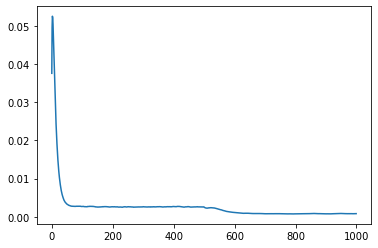

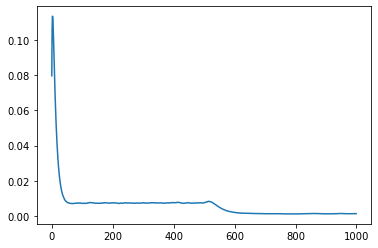

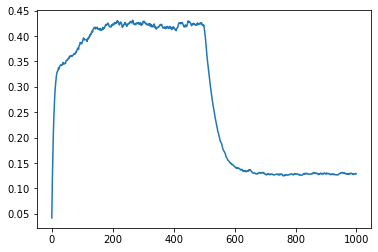

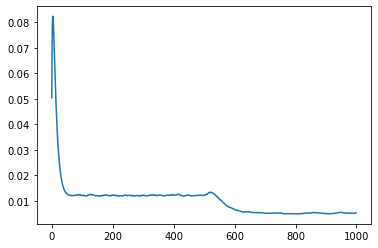

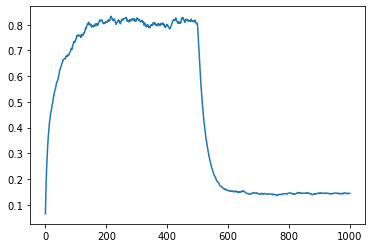

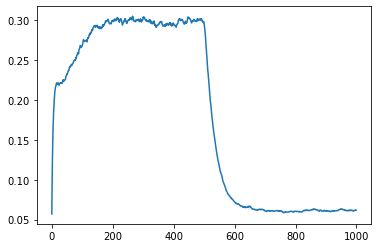

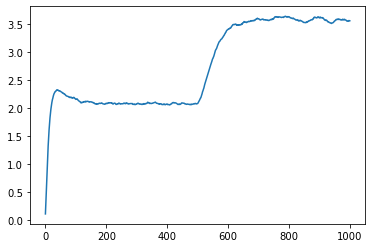

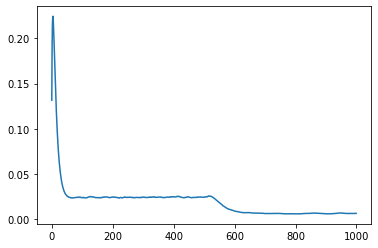

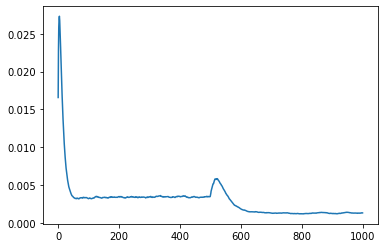

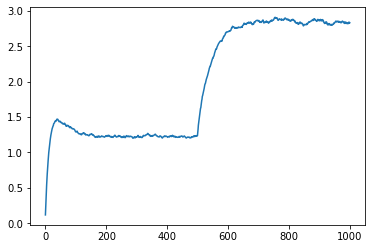

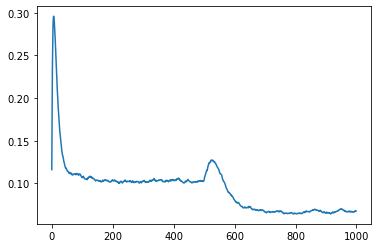

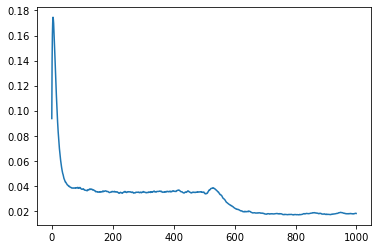

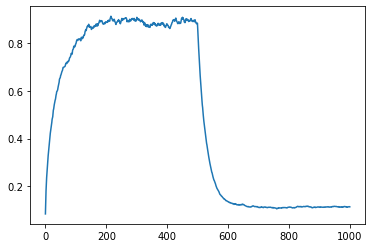

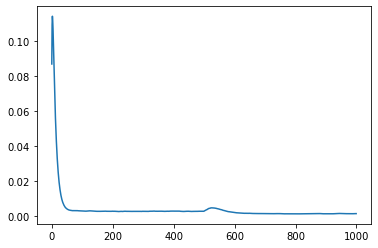

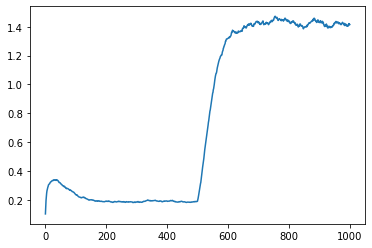

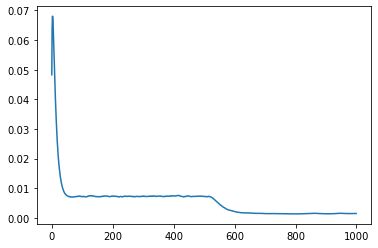

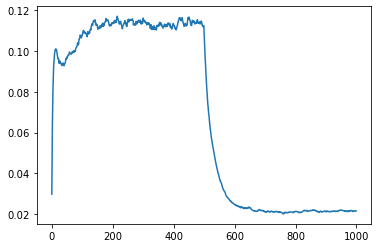

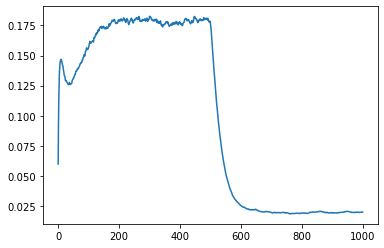

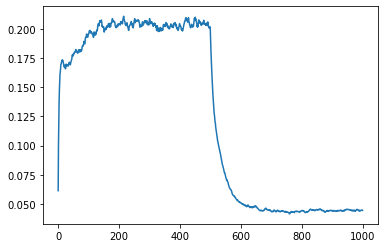

In [24]:
for i in range(100):
    fig, ax = plt.subplots()
    plt.plot(range(len(activations[:,i])), activations[:,i])
    plt.show()

In [25]:
net_weight_history = weight_history['trained weights']

In [26]:
print(len(net_weight_history))

20


Plotting change in singular values over training iteration

In [27]:
num_singular_values = 100
values = []
variance_prop = []
for mat in tqdm(net_weight_history):
    u, s, vh = np.linalg.svd(mat)
    values.append(s[:num_singular_values])
    tot_variance = np.dot(s,s)
    variance_prop.append([val**2/tot_variance for val in s])

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.26it/s]


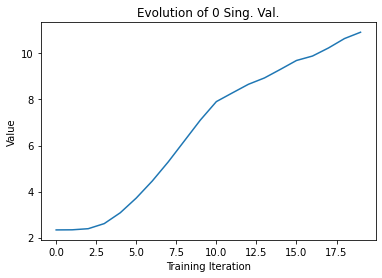

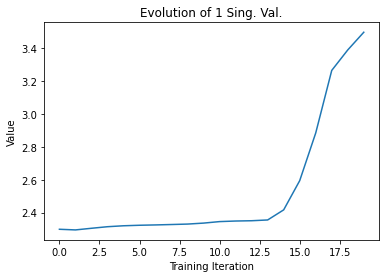

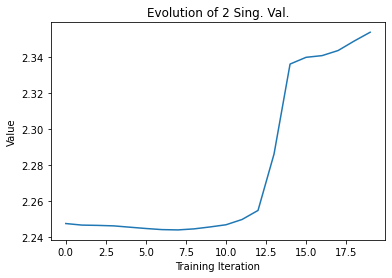

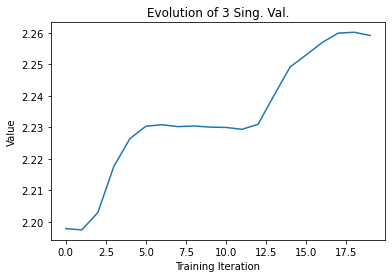

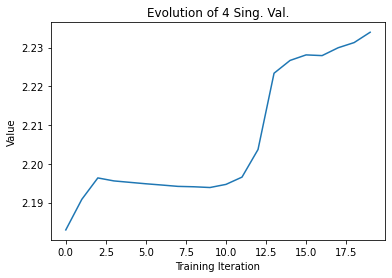

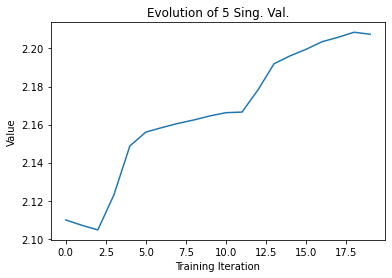

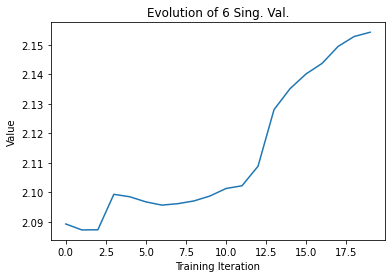

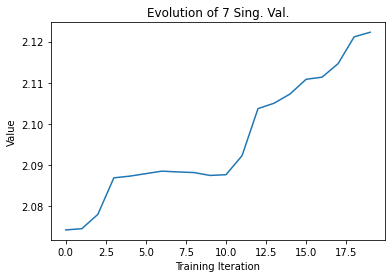

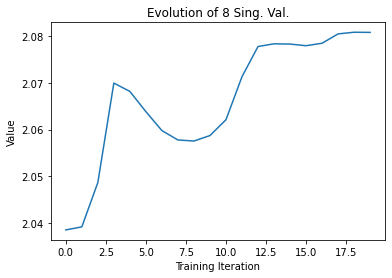

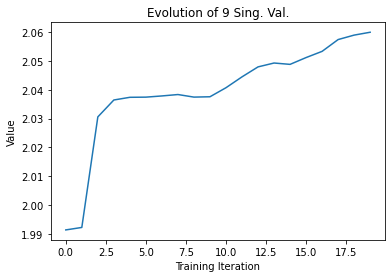

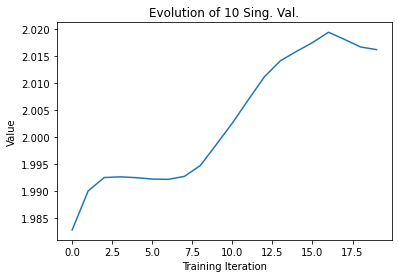

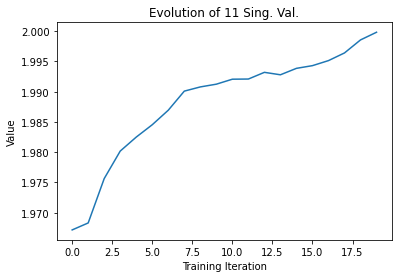

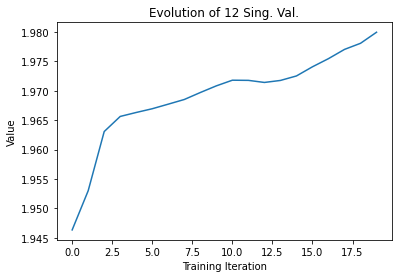

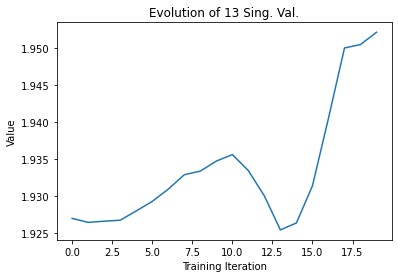

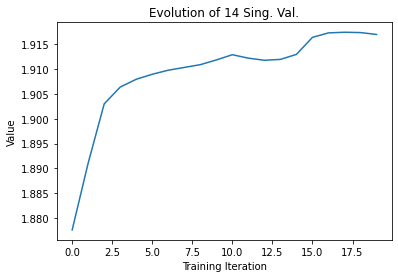

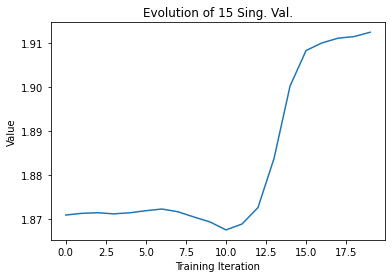

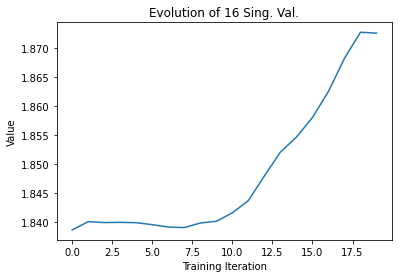

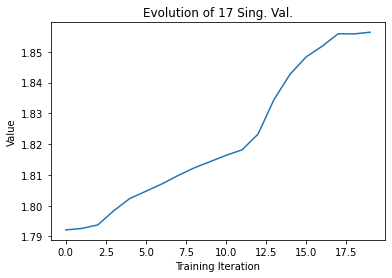

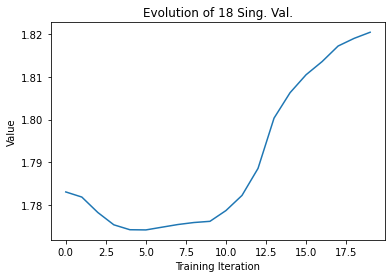

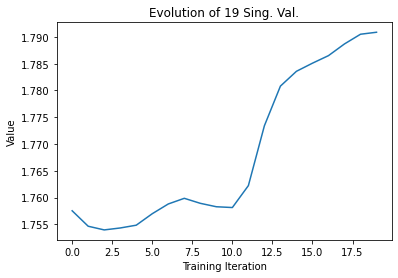

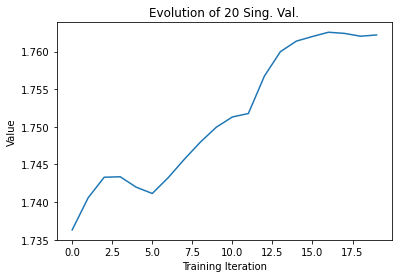

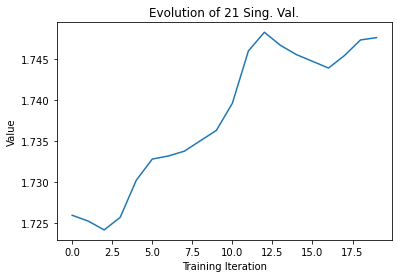

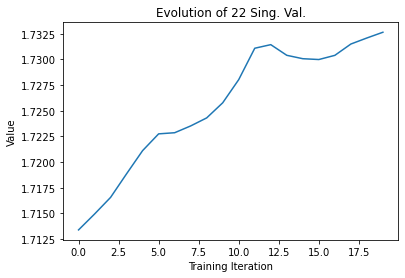

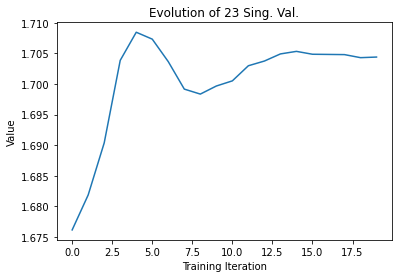

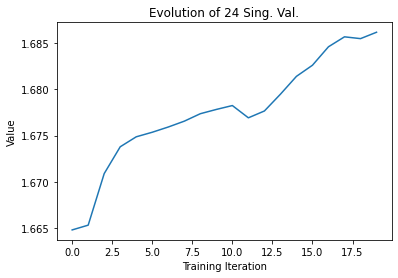

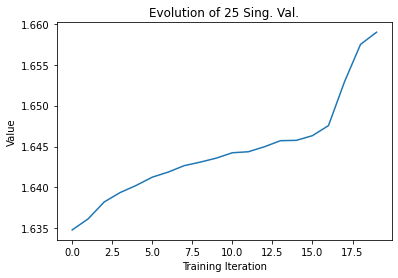

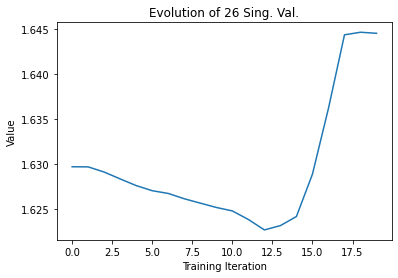

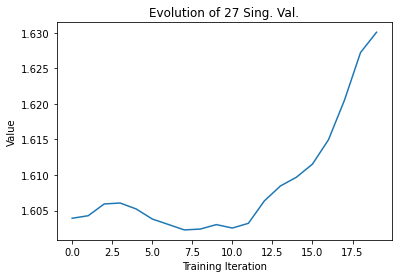

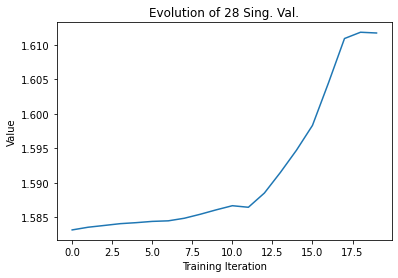

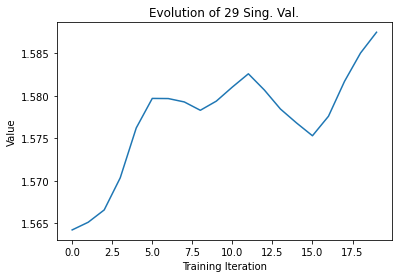

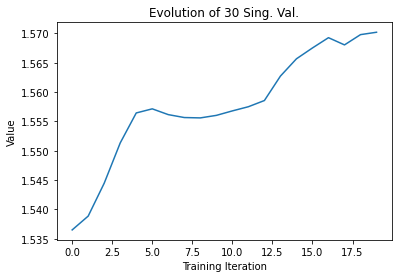

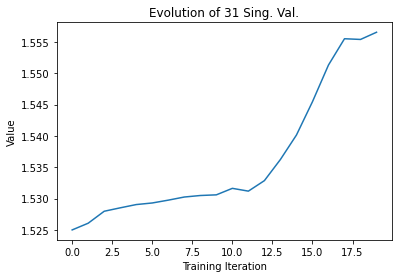

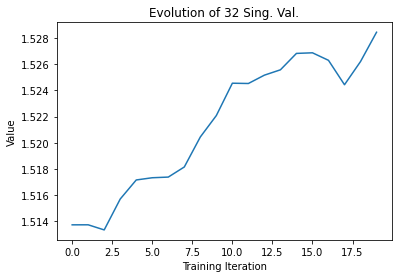

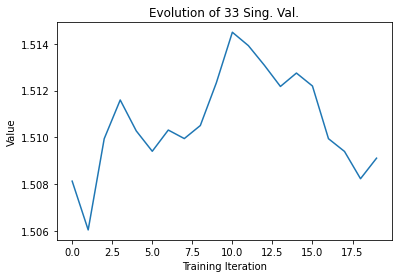

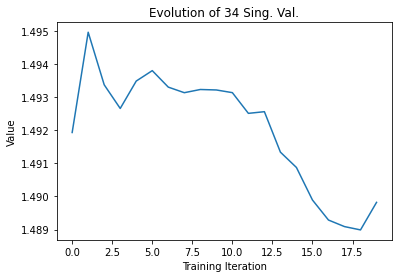

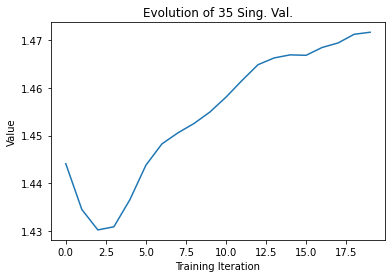

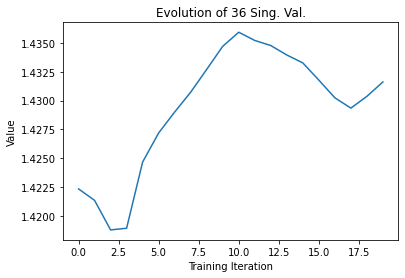

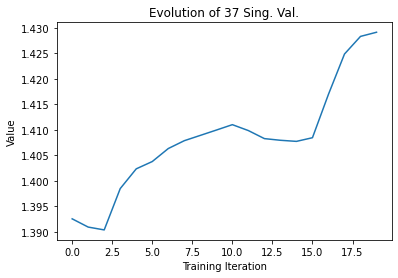

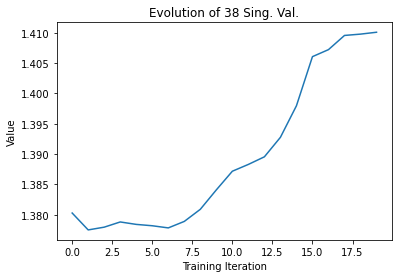

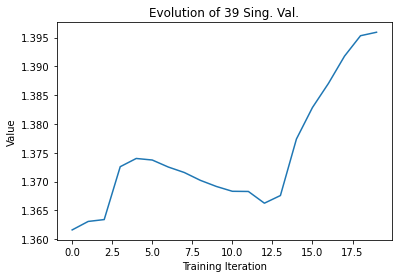

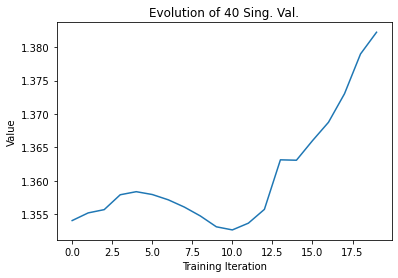

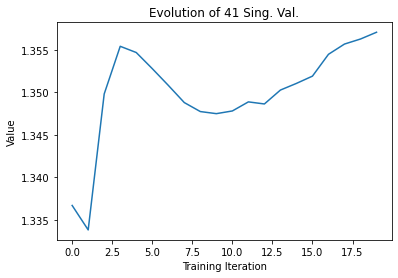

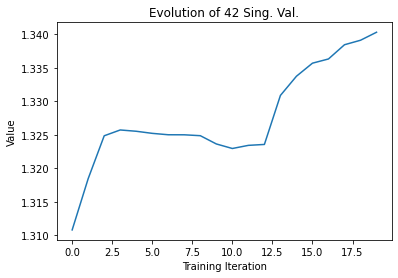

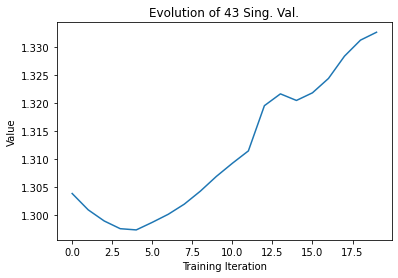

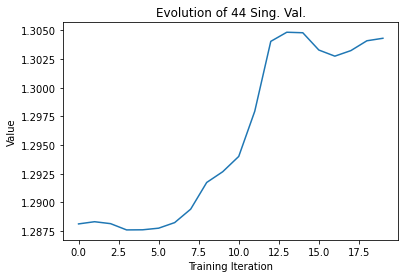

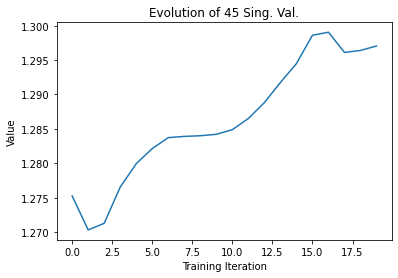

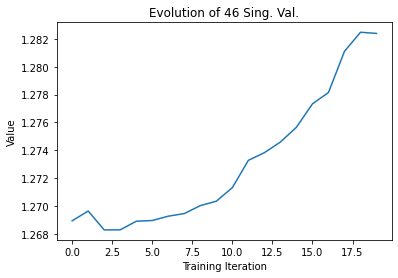

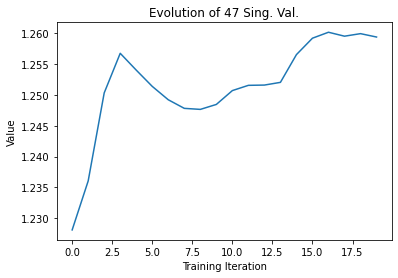

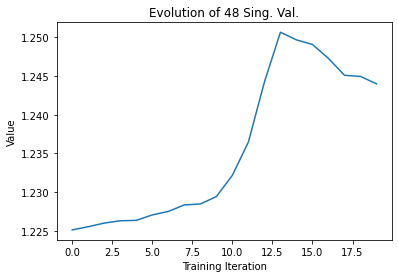

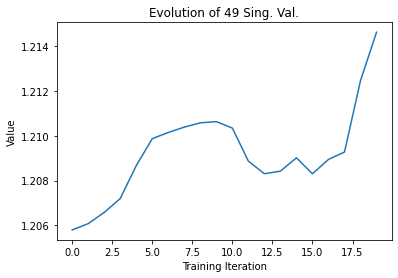

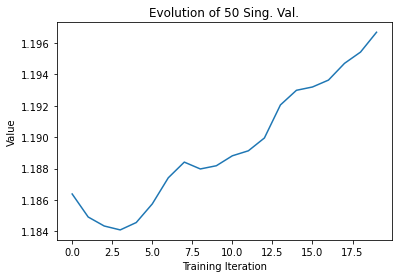

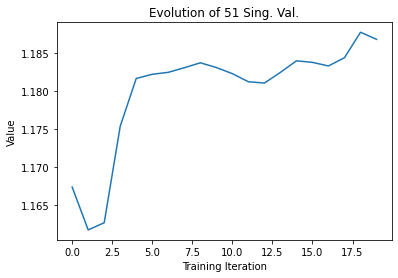

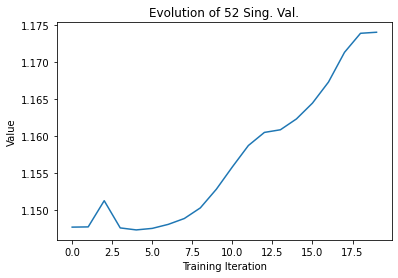

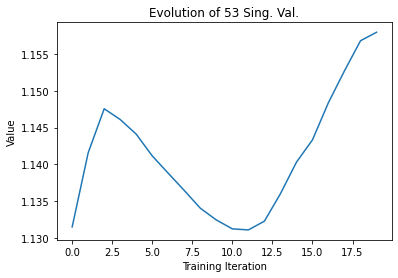

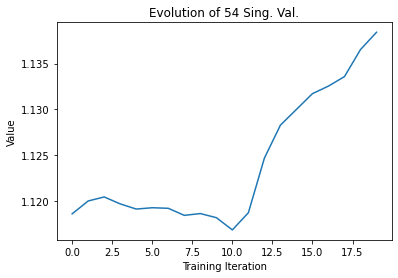

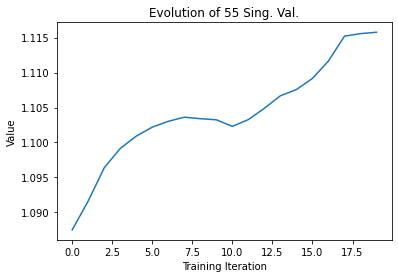

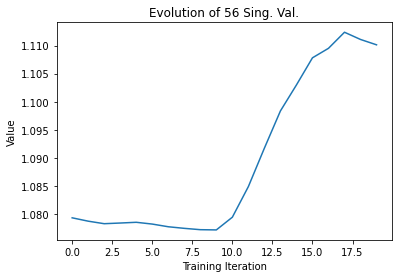

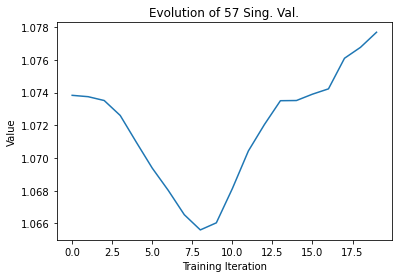

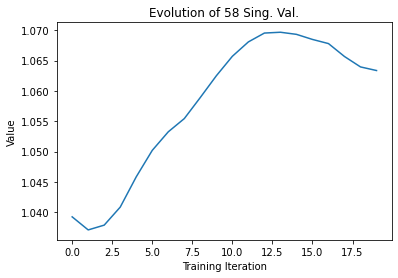

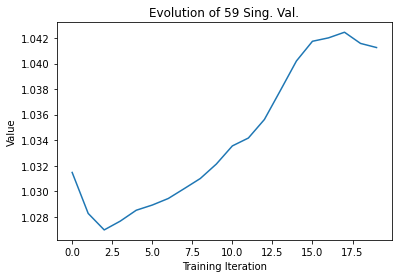

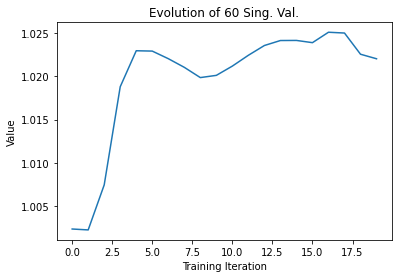

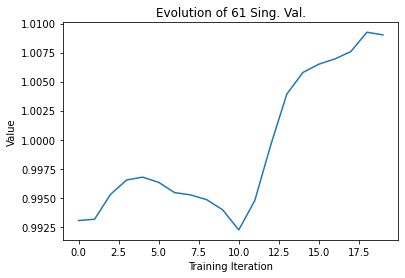

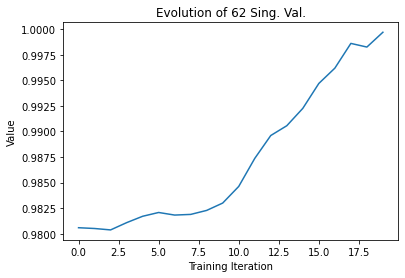

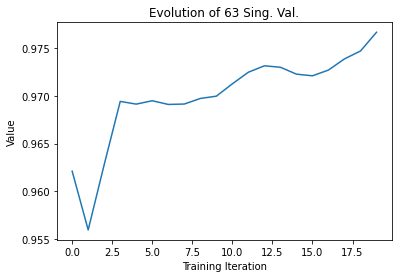

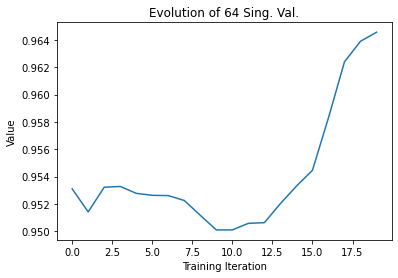

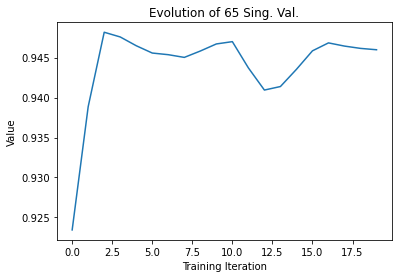

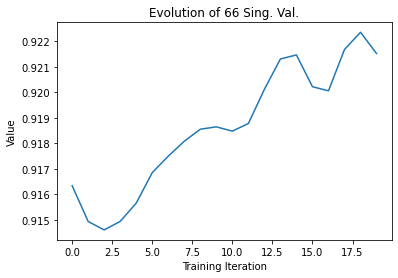

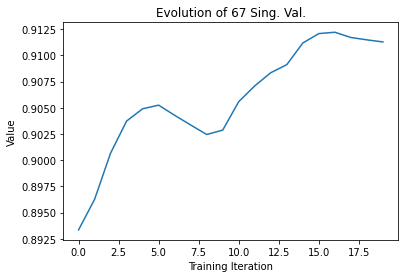

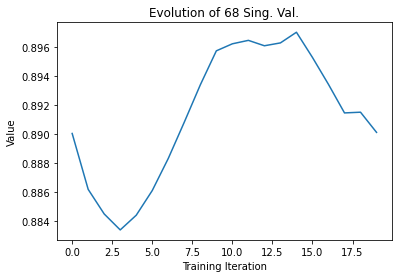

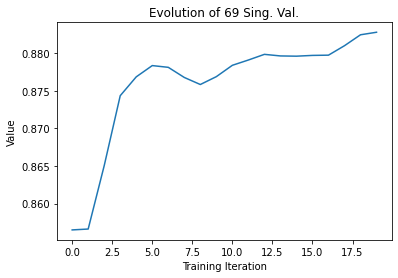

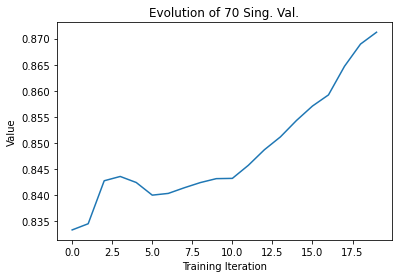

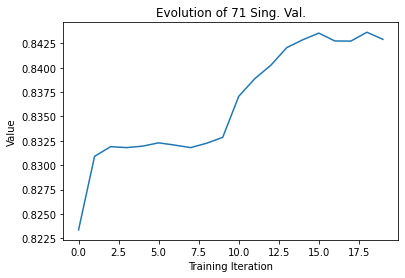

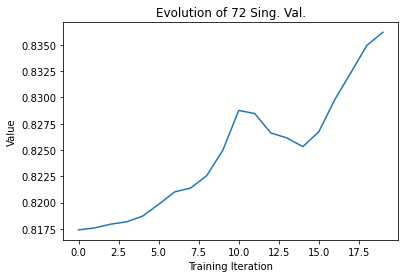

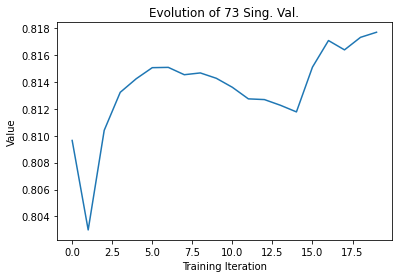

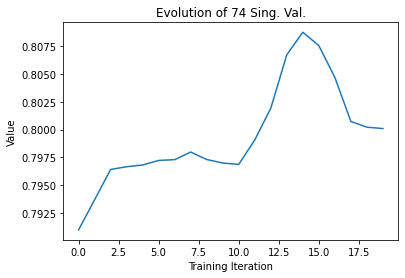

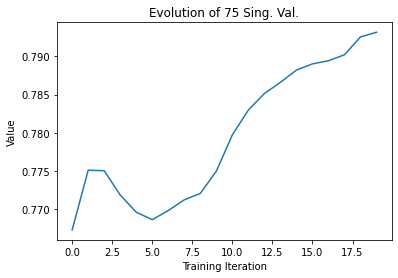

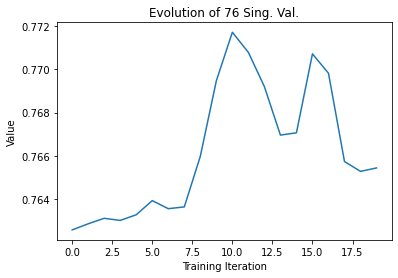

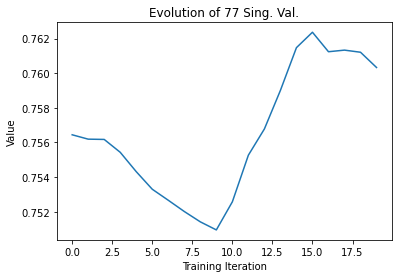

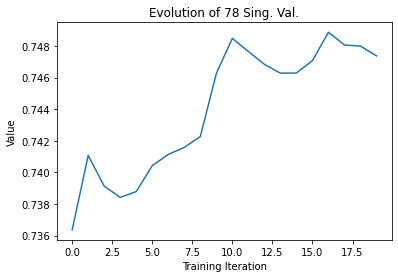

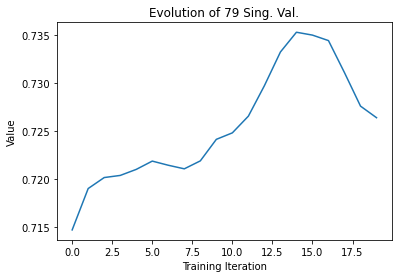

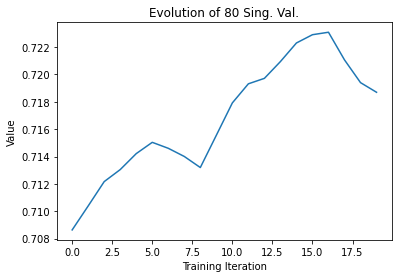

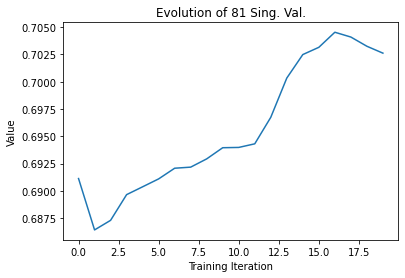

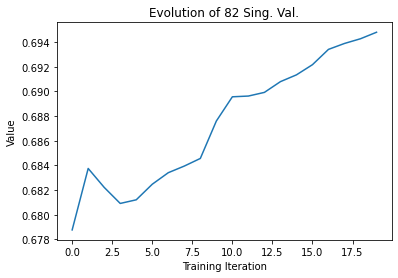

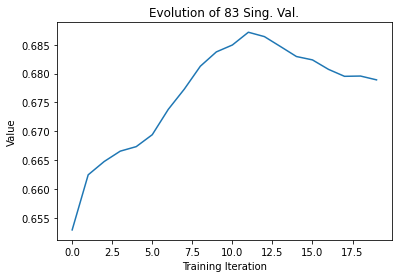

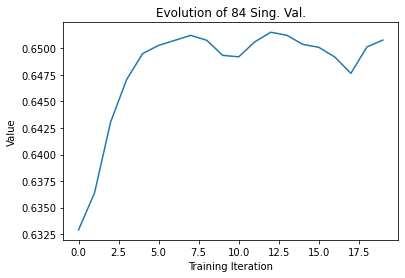

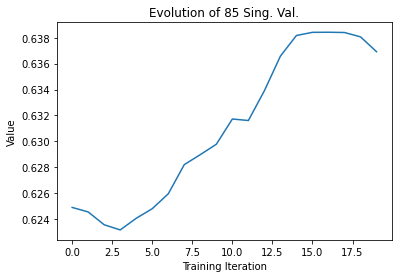

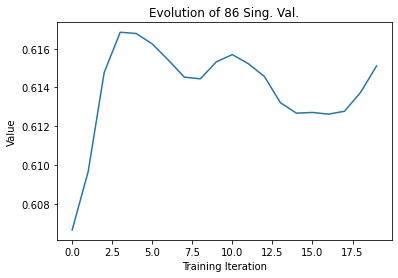

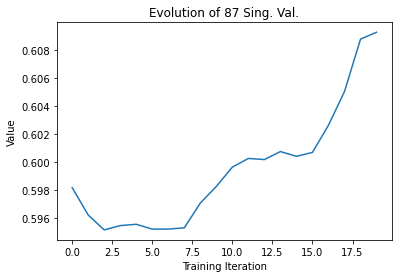

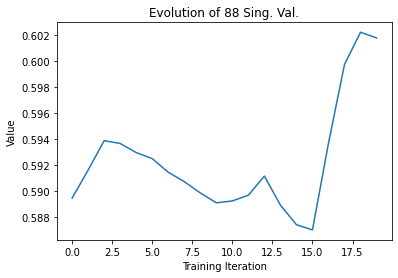

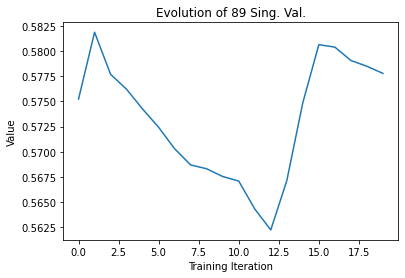

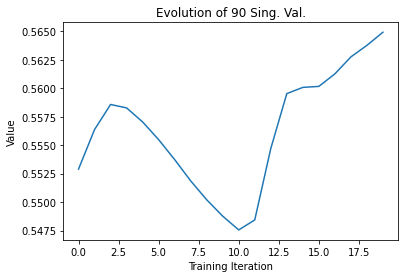

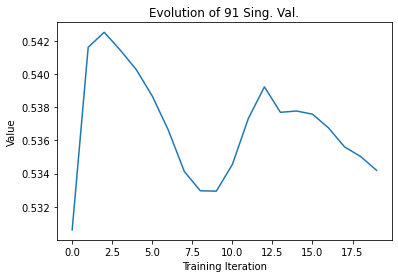

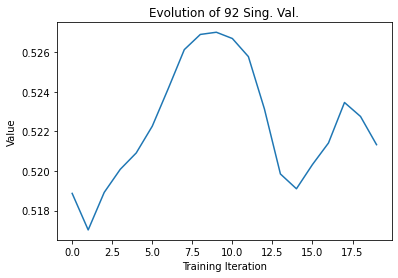

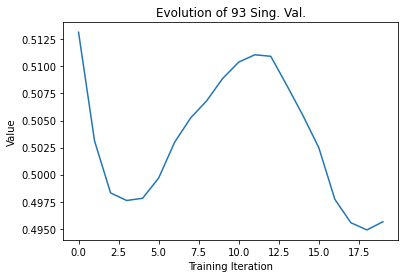

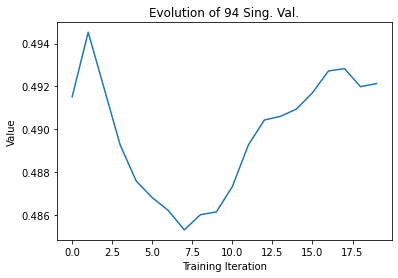

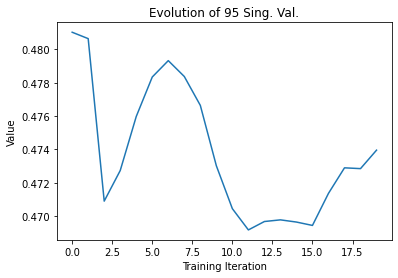

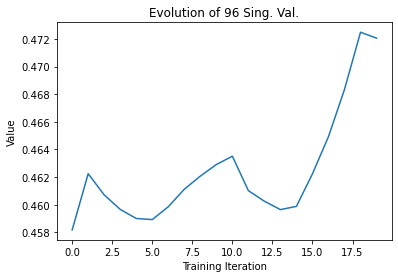

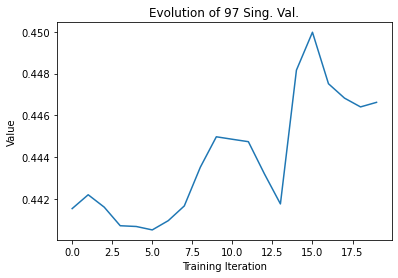

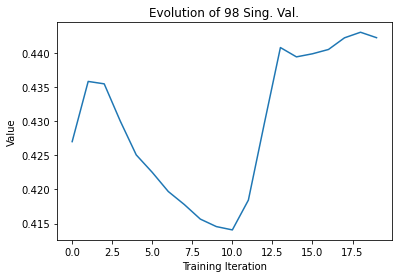

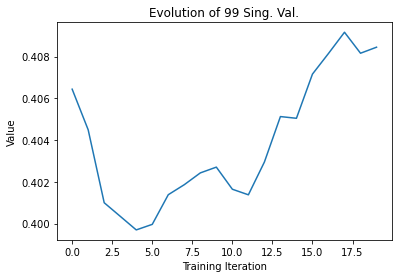

In [28]:
#The i'th column is the evolution of the i'th singular value
values = np.asarray(values)
num_total_iters = values[:, 0].shape[0]

for i in range(num_singular_values):
    fig, ax = plt.subplots()
    plt.plot(range(num_total_iters), values[:, i])
    plt.title('Evolution of ' + str(i) + ' Sing. Val.')
    plt.xlabel('Training Iteration')
    plt.ylabel('Value')
    plt.show()


Plotting percent variance captured in singular values over training iteration

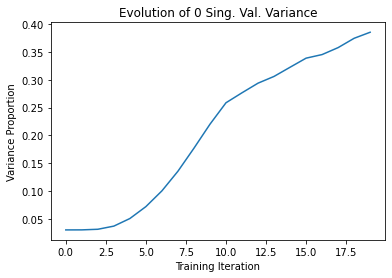

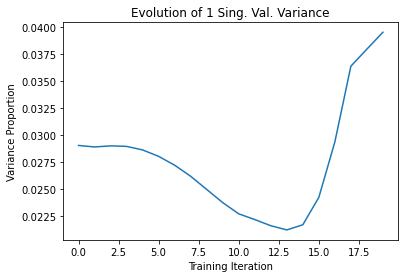

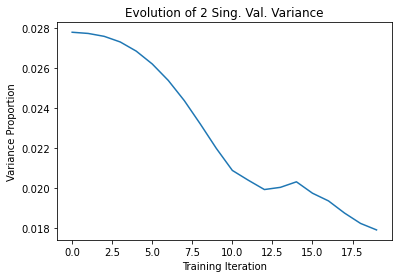

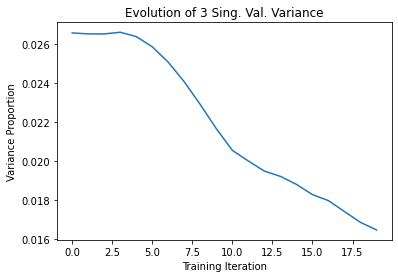

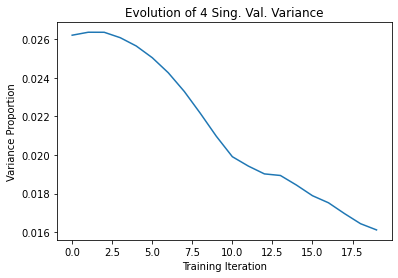

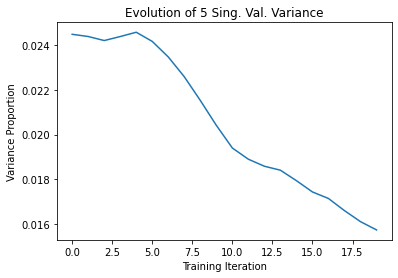

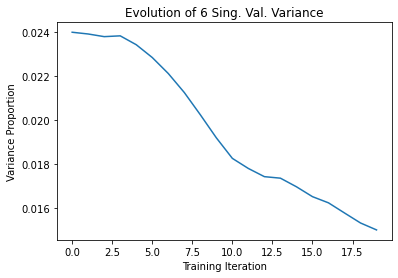

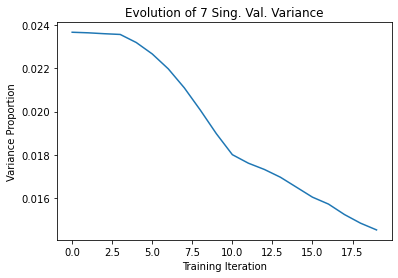

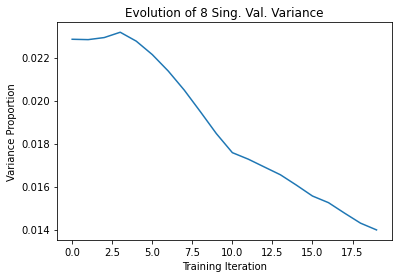

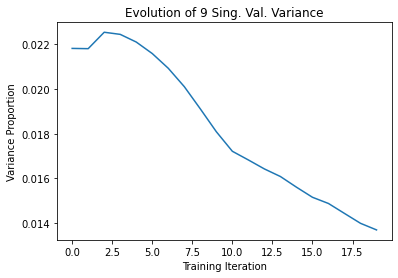

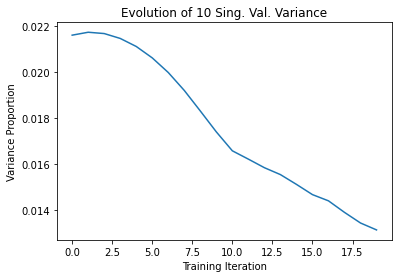

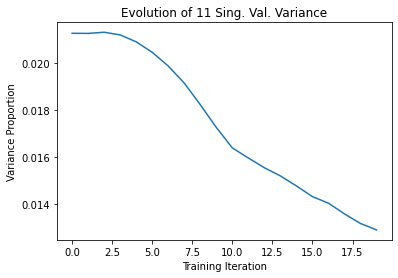

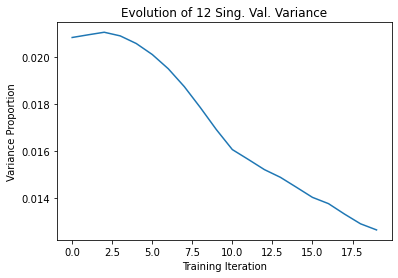

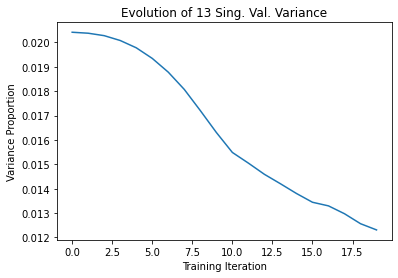

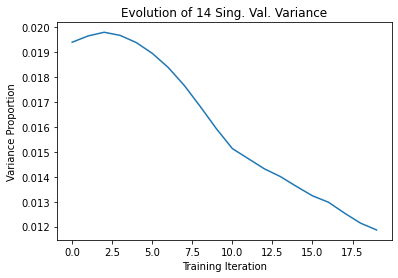

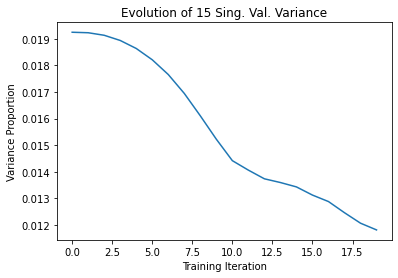

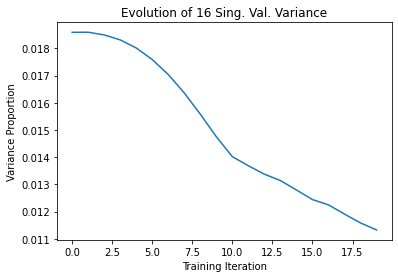

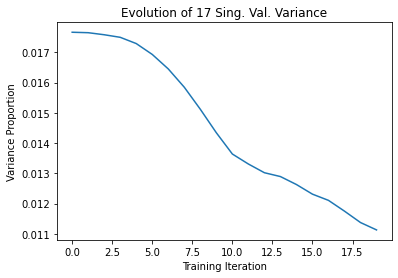

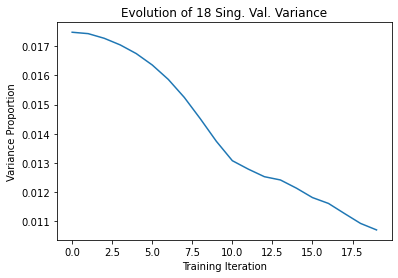

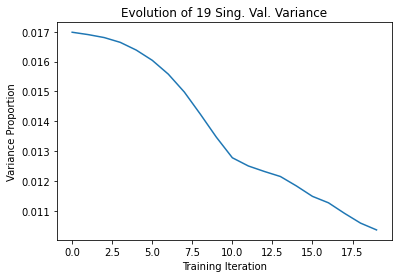

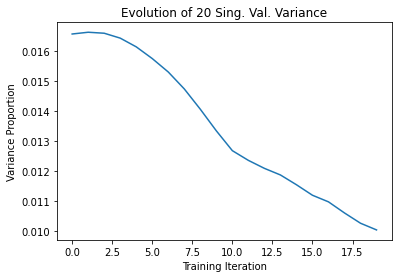

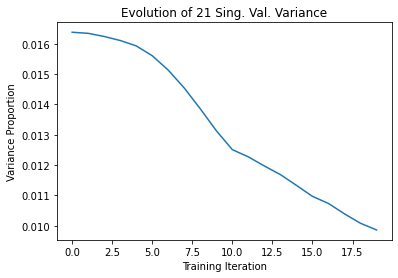

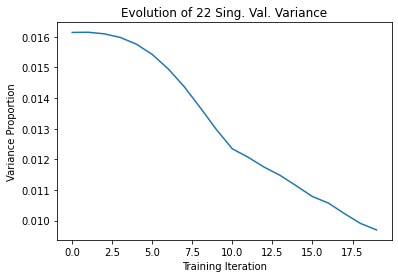

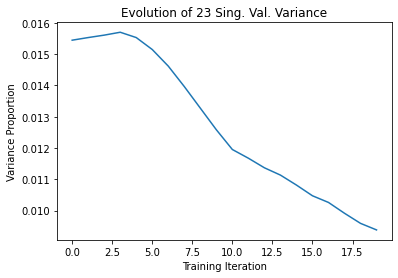

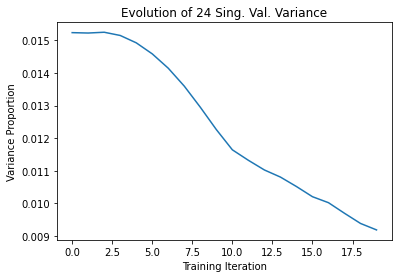

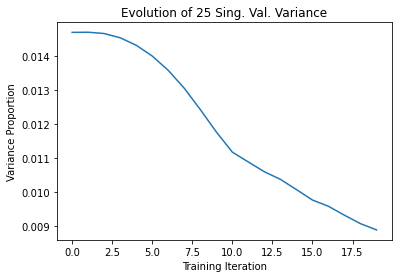

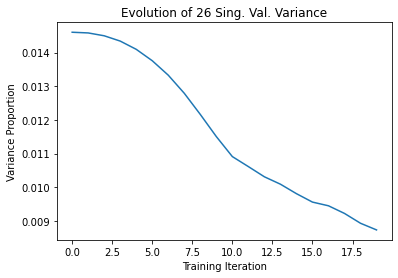

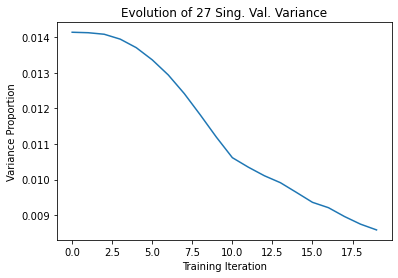

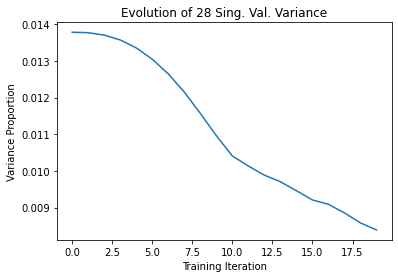

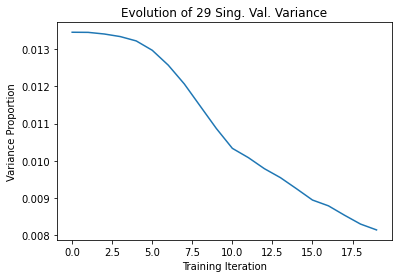

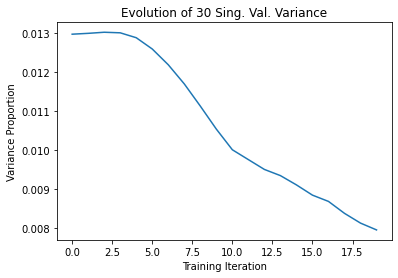

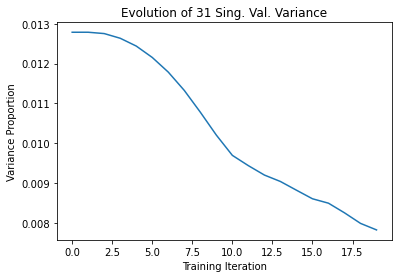

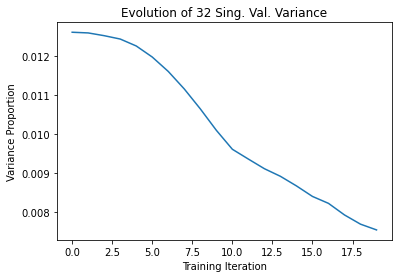

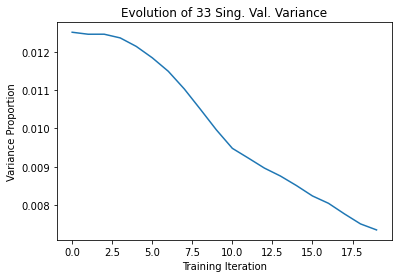

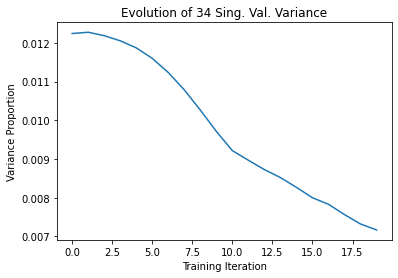

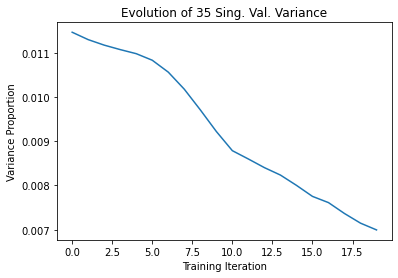

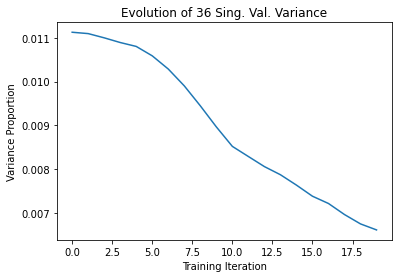

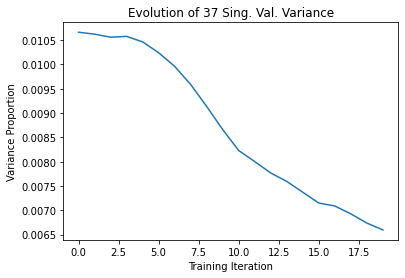

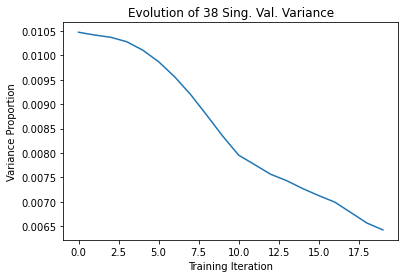

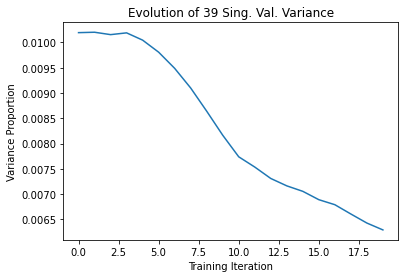

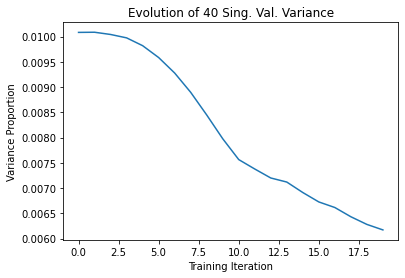

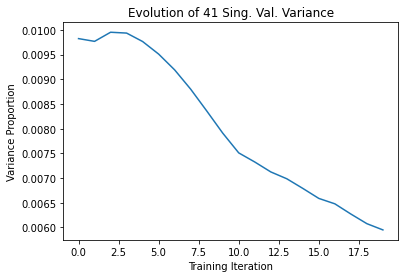

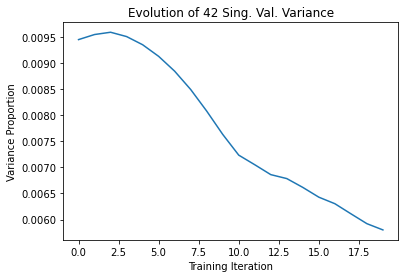

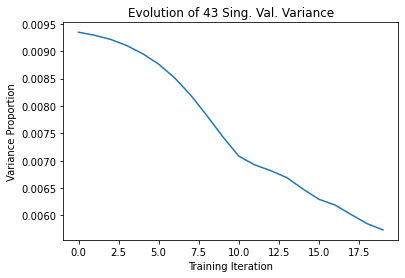

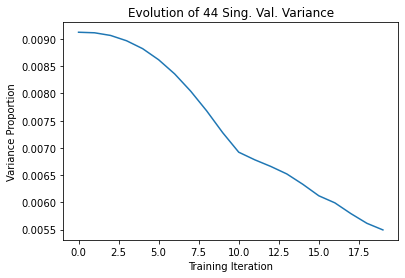

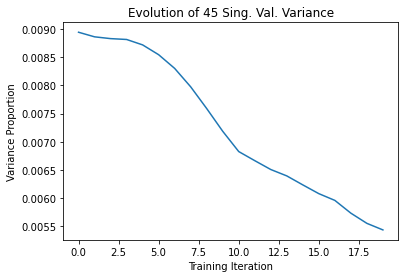

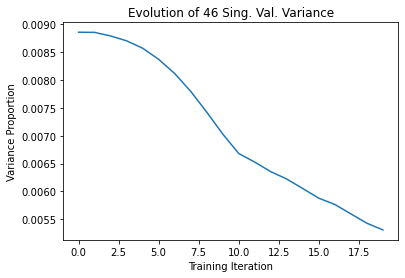

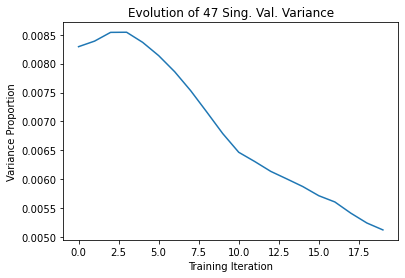

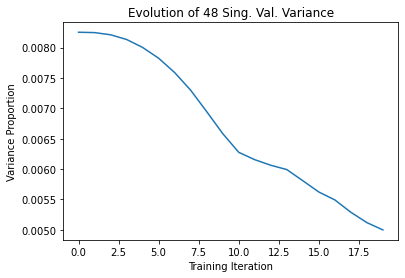

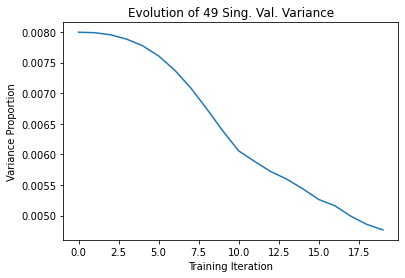

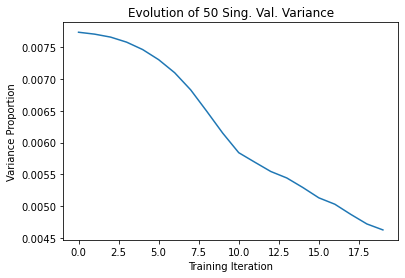

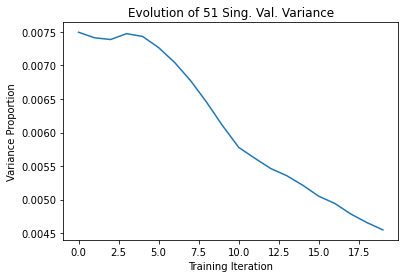

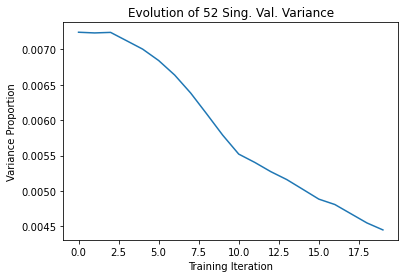

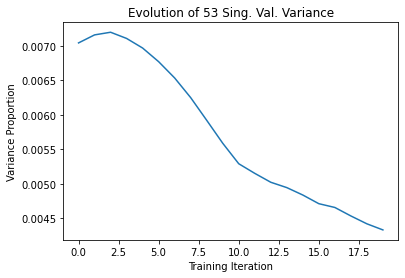

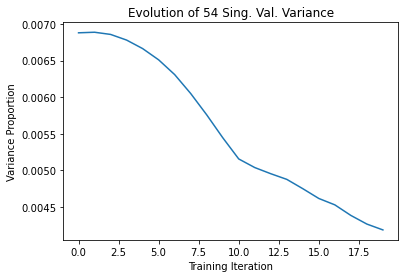

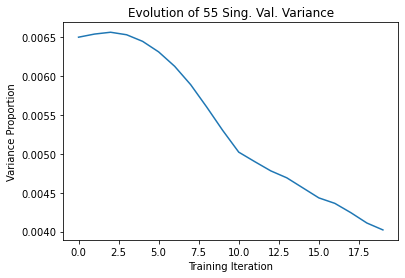

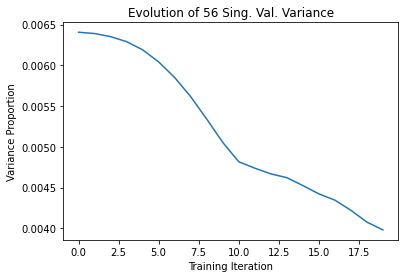

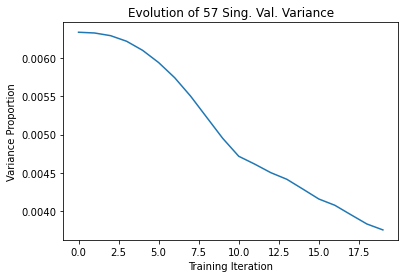

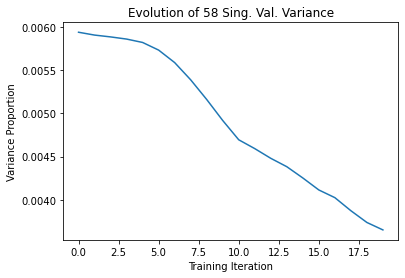

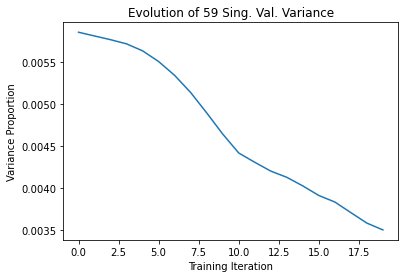

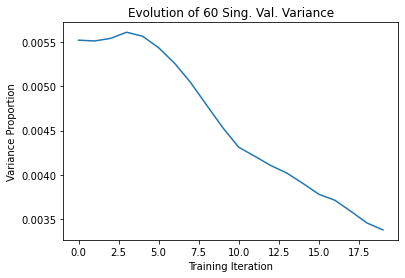

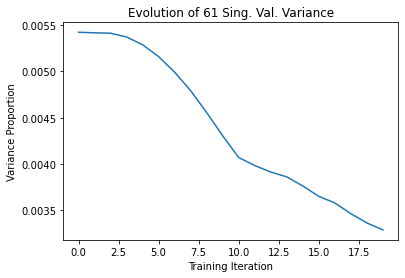

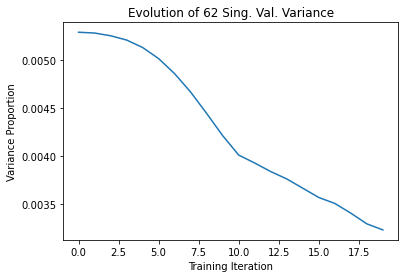

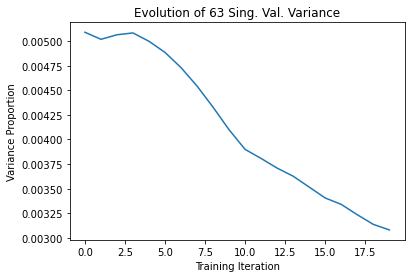

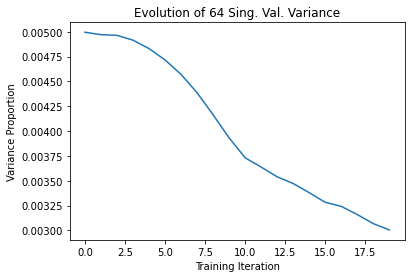

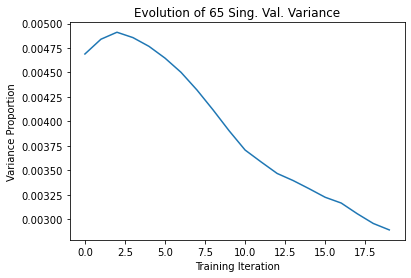

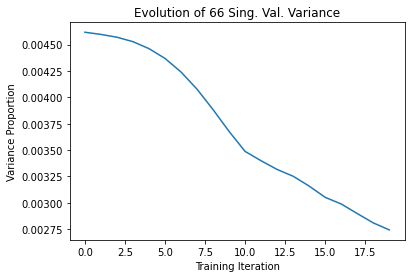

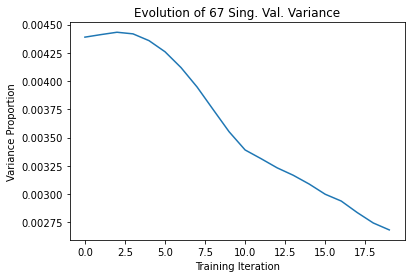

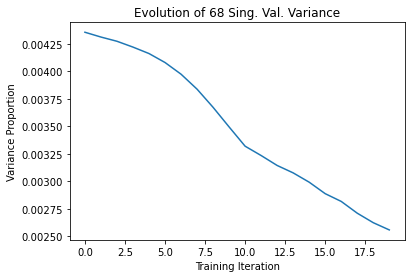

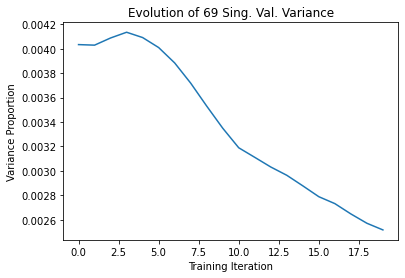

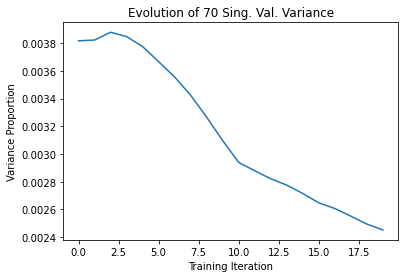

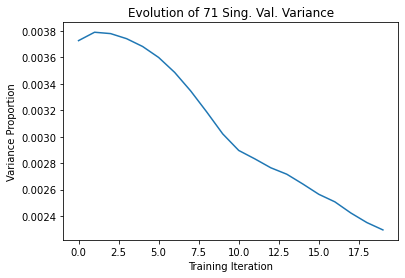

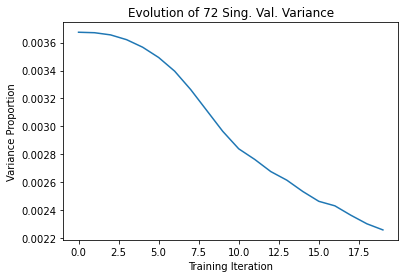

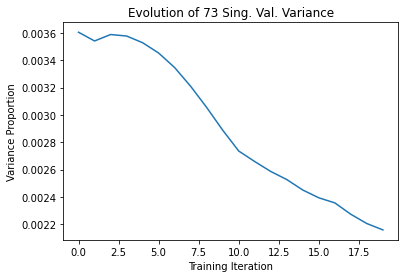

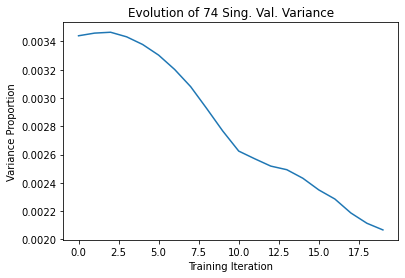

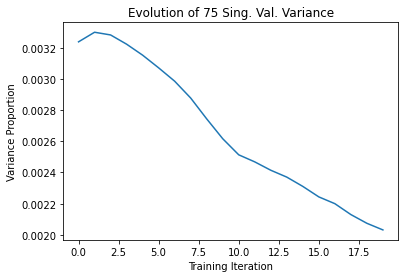

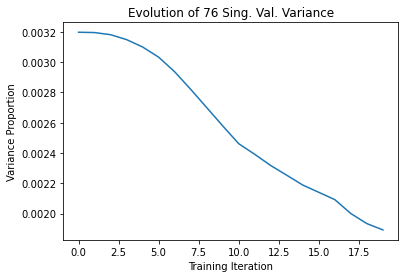

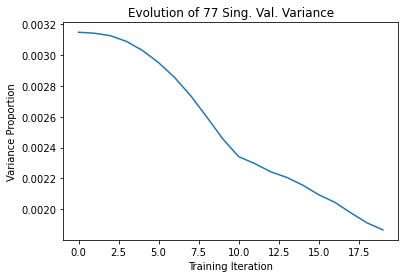

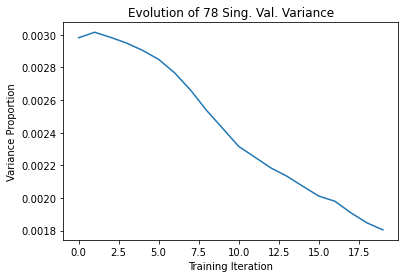

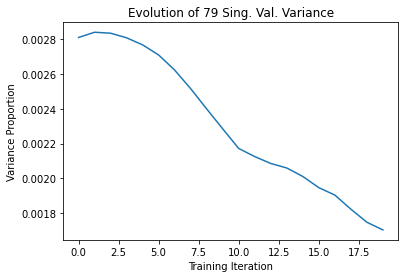

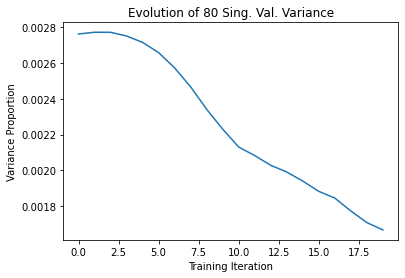

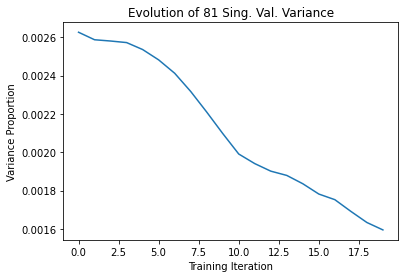

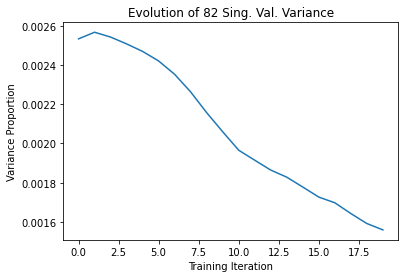

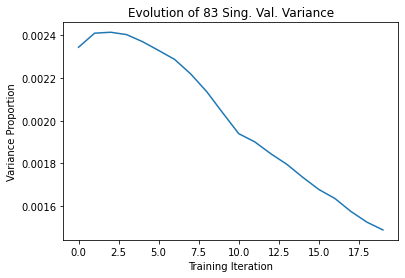

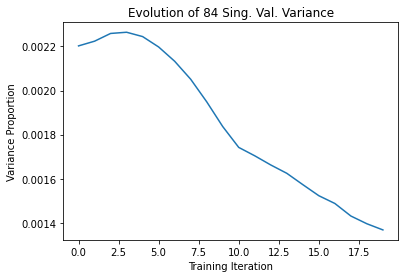

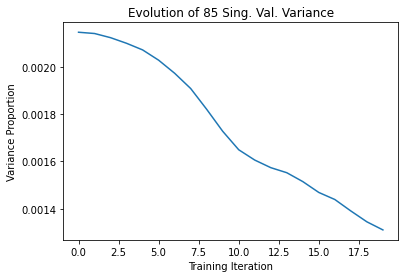

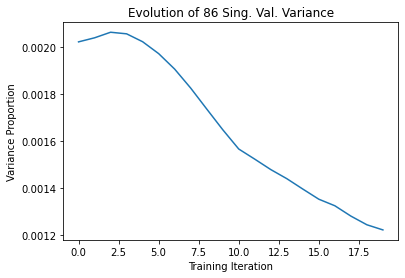

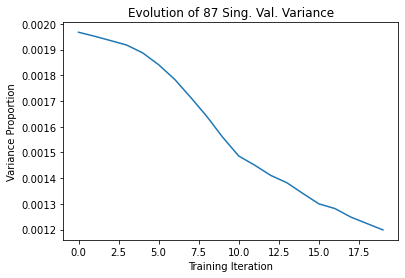

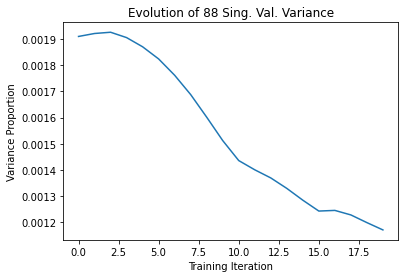

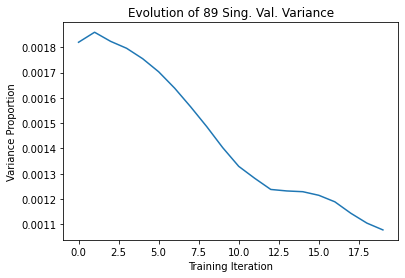

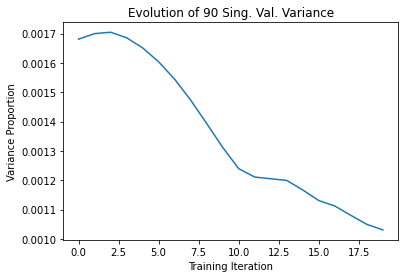

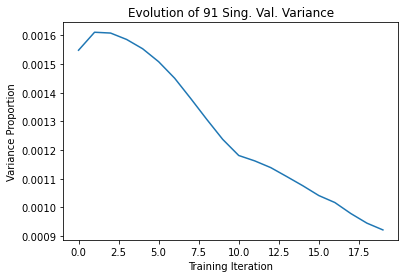

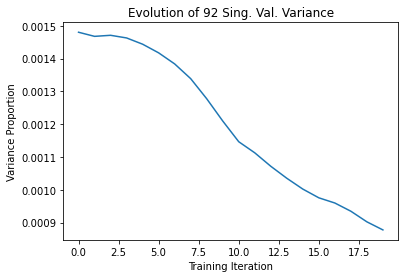

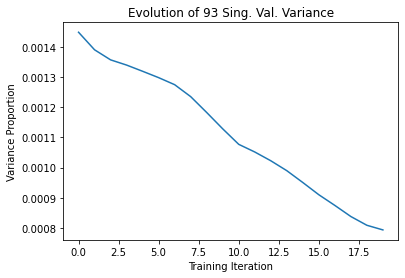

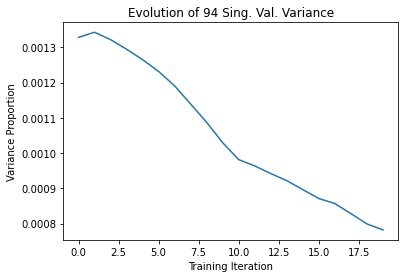

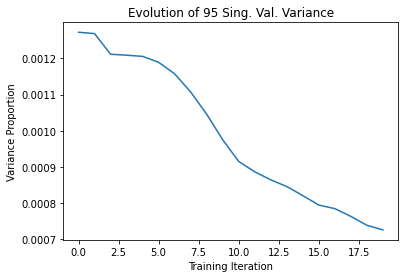

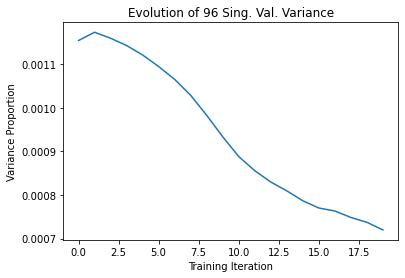

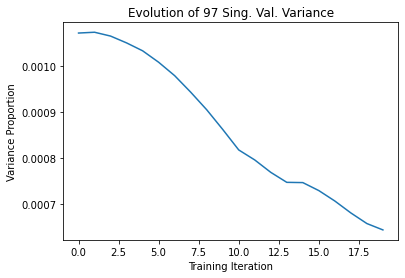

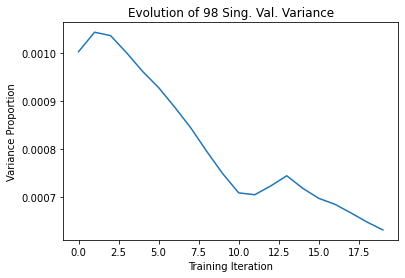

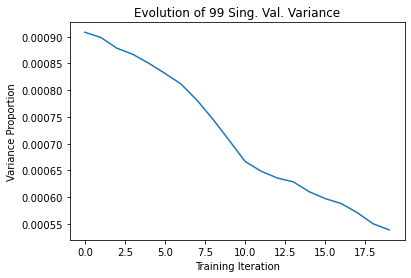

In [29]:
variance_prop = np.asarray(variance_prop)
for i in range(num_singular_values):
    fig, ax = plt.subplots()
    plt.plot(range(num_total_iters), variance_prop[:, i])
    plt.title('Evolution of ' + str(i) + ' Sing. Val. Variance')
    plt.xlabel('Training Iteration')
    plt.ylabel('Variance Proportion')
    plt.show()

Plotting sum of squares of off-diagonal components in schur decomposition of the matrices over training iteration

In [30]:
values = []
for mat in tqdm(net_weight_history):
    T, Z = slin.schur(mat)
    values.append(np.linalg.norm(T))
values = np.asarray(values)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.75it/s]


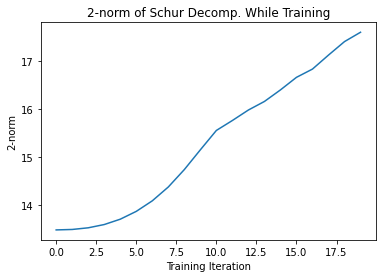

In [31]:
fig, ax = plt.subplots()
plt.plot(range(num_total_iters), values)
plt.xlabel('Training Iteration')
plt.ylabel('2-norm')
plt.title('2-norm of Schur Decomp. While Training')
plt.show()

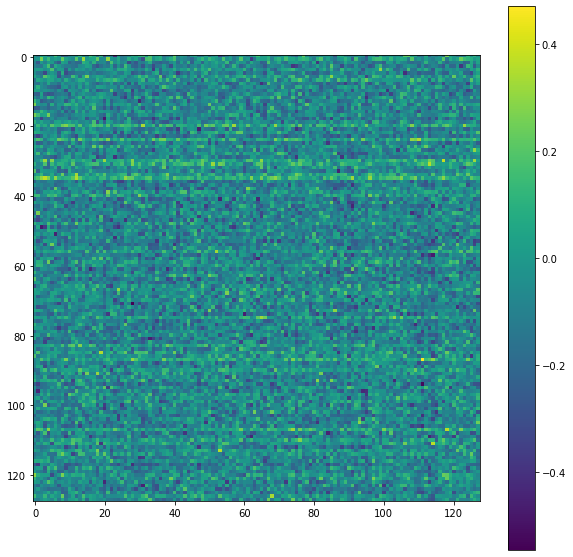

In [32]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
plt.imshow(final_weights)
plt.colorbar()

In [33]:
np.mean(final_weights)

-0.06419903073215227

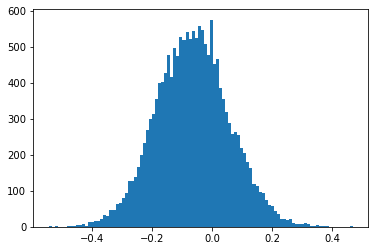

In [34]:
flattened = final_weights.flatten()
plt.hist(flattened, bins = 100)
plt.show()

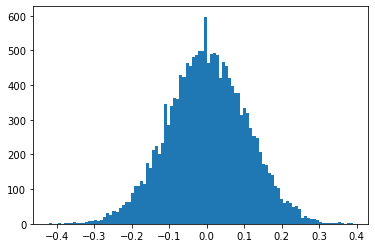

In [35]:
init = np.array(weight_history['trained weights'][0])
flattened = init.flatten()
plt.hist(flattened, bins = 100)
plt.show()

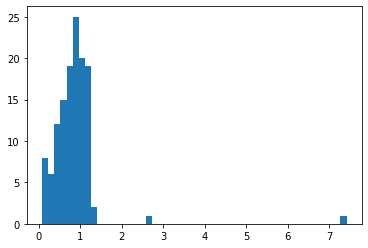

In [36]:
eig = np.linalg.eigvals(final_weights)
plt.hist(np.abs(eig), bins = 50)
plt.show()